In [7]:
#this notebook loads the contig numbers associated with each cluster made through
# tSNE and HDBscan for a given set of experiments. 
# then makes a single fasta file - which is useful for running through Checkm (done on Sherlock)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import matplotlib.patches as patches
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import re
import ast
import HTSeq
from Bio import SeqIO

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines',lw=2) 
sns.set(font_scale = 2)

# dereks function for optimal leaf clustering
def _optimal_order(data, **kwargs):
    """ Optimal leaf ordering
        **kwargs passed to pdist e.g. metric='correlation'
    """
    d = pdist(data, **kwargs)
    link = linkage(d, method='average')
    optimal_order = optimal_leaf_ordering(link, d)
    return optimal_order

from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage
from polo import optimal_leaf_ordering

In [8]:
alt = pd.read_pickle('ObsCom_alt')
alt5 = pd.read_pickle('ObsCom_alt5')
alt5['length'].sum()/1e6


300.907778

In [4]:
# this nb is for making a final list of (partially) manually curated genomes 
# this includes 
# 1) the original bin names (e.g. Obs4_mini_1, M50, ...) (alt 5)
# 2) the genome names as sent to Brian for re-assembly (alt 5 number of genomes)
# 3) the genome names as sent to Frederik for the provisional tree building (alt 5 checkm pass - 'good genomes')
# 4) metadata (i.e. checkm stats, reliability/completeness according to Frederik's metrics etc.)


In [9]:
# load original genomes 
alt = pd.read_pickle('ObsCom_alt') #ungrouped 
alt5 = pd.read_pickle('ObsCom_alt5') #grouped (with M numbers)
alt5['length'].sum()/1e6

# load the reference file with changed names for Brian (+ metadata checkm on these)
brian = pd.read_table('fasta/genome_bins_obsidian/info.table')

# load the reference file made for Frederik
fred = pd.read_table('fasta/for_frederik/info.table')

In [10]:
def read_checkm_tsv(filedir):
    # read the checkm bin_stats_ext.tsv file (this has the other metadata like GC etc)
    metadata = list(open(filedir+'storage/bin_stats_ext.tsv'))
    metadata = [m.split('\n') for m in metadata]
    metadf = pd.DataFrame.from_records(metadata)
    metadf = metadf.drop(1,1)
    metadf.columns = ['bla']
    metadf = metadf['bla'].str.split('\t',1,expand=True)
    metadf = metadf.set_index(0)
    metadf.columns = ['metadata']

    columns = ['marker lineage','Completeness','Contamination','# contigs','Genome size','# genomes','# marker sets','# markers','# predicted genes','Coding density','GC','GC std','Longest contig','Mean contig length','N50 (contigs)']
    metadata_obs = pd.DataFrame(index=metadf.index,columns=columns)

    for d in metadf.index:
        dictionary = ast.literal_eval(metadf.loc[d,'metadata'])
        for j in metadata_obs.columns:
            metadata_obs.loc[d,j] = dictionary[j]
    checkm_metadata = metadata_obs.copy()
    #checkm_metadata.to_pickle(filedir+'metadata_pickle')
    return(checkm_metadata)

def make_checkm_output_df(filedir):
    # run the read_checkm_tsv and add the outputfile.txt
    meta = read_checkm_tsv(filedir)
    strhet = pd.read_table(filedir+'outputfile.txt')
    strhet = strhet.set_index('Bin Id')
    
    meta = meta.join(strhet['Strain heterogeneity'])
    meta = meta.sort_values('Completeness',ascending=False)
    return(meta)

# find the original bin index of the metadata file and replace 
def get_old_bin_names(meta_new,startidx,stopidx):
    # this assumes translation df exists 
    transl = pd.read_table('fasta/genome_bins_obsidian/info.table')
    
    meta_new['old_idx'] = '';meta_new['sample']=''
    for brian_name in meta_new.index:
        brian_idx = brian_name[startidx:stopidx]
        meta_new.loc[brian_name,'old_idx'] = transl[transl['NewName'].str[-3:]==brian_idx].set_index('Unnamed: 0').index[0]+'_'+brian_name[-1] #ds
        meta_new.loc[brian_name,'sample'] = transl[transl['NewName'].str[-3:]==brian_idx]['sample'].values[0]
    meta_new_setidx = meta_new.set_index('old_idx')
    #meta_old['sample'] = meta_new_setidx['sample']
    #meta_old_setidx = meta_old[meta_old.index.isin(meta_new_setidx.index)]
    return(meta_new_setidx)

In [11]:
checkm_out_original_all = make_checkm_output_df('Checkm/obsidian_all_checkm/')
checkm_out_manual_genomes = make_checkm_output_df('Checkm/Manual_genomes_obs/round2_results/')

#len(checkm_out_manual_genomes[checkm_out_manual_genomes['r_sub']=='1'])
Obs_genome_overview = checkm_out_original_all.copy()
#.loc[brian.set_index('Unnamed: 0').index,:]
Obs_genome_overview['sample'] = brian.set_index('Unnamed: 0')['sample']
Obs_genome_overview['name_brian'] = brian.set_index('Unnamed: 0')['NewName']
Obs_genome_overview['name_fred'] = fred.set_index('Bin Id')['NewName']
#Obs_genome_overview['name_fred'].dropna()

In [12]:
checkm_out_manual_genomes['oldname'] = ''
checkm_out_manual_genomes['sub'] = [s[-1] for s in checkm_out_manual_genomes.index]
for s in checkm_out_manual_genomes.index:
    
        checkm_out_manual_genomes.loc[s,'oldname'] = Obs_genome_overview[Obs_genome_overview['name_brian'].str.contains(s[-5:-2])==True].index[0]
    
for c in checkm_out_manual_genomes.columns:
    checkm_out_manual_genomes = checkm_out_manual_genomes.rename(columns={c:'r_'+c})

In [13]:


Obs_genome_overview = Obs_genome_overview.join(checkm_out_manual_genomes[checkm_out_manual_genomes['r_sub']=='1'].set_index('r_oldname'))
Obs_genome_overview = Obs_genome_overview.append(checkm_out_manual_genomes[checkm_out_manual_genomes['r_sub']=='2'].set_index('r_oldname'))
Obs_genome_overview = Obs_genome_overview.append(checkm_out_manual_genomes[checkm_out_manual_genomes['r_sub']=='3'].set_index('r_oldname'))
#Obs_genome_overview[Obs_genome_overview.index=='Obs4_mega_6'][['marker lineage','r_marker lineage','name_brian']]
Obs_genome_overview['numidx']=range(0,len(Obs_genome_overview))
doublist = list(Obs_genome_overview[Obs_genome_overview['r_sub']=='2'].index)
Obs_genome_overview['cluster_old'] = Obs_genome_overview.index
Obs_genome_overview = Obs_genome_overview.set_index('numidx',append=False)



for el in doublist:
    idxlist = Obs_genome_overview[Obs_genome_overview['cluster_old']==el].index
    Obs_genome_overview.iloc[idxlist[1],0:17] = Obs_genome_overview.iloc[idxlist[0],0:17]
    if len(idxlist)>2:
        Obs_genome_overview.iloc[idxlist[2],0:17] = Obs_genome_overview.iloc[idxlist[0],0:17]


In [14]:
fred[fred['Bin Id']=='Obs6_meta_31']

,Bin Id,NewName,sample,Completeness,Contamination,Strain heterogeneity


In [15]:

# this is a stupid hack, for now 
clust_tree_ = ['Obs4_genome_001','Obs4_genome_011','Obs2_genome_019','Obs2_genome_022',
              'Obs3_genome_012','Obs4_genome_007','Obs2_genome_016']
made_tree_bact = ['Obs5_genome_009','Obs5_genome_010','Obs5_genome_002','Obs3_genome_032',
            'Obs3_genome_031','Obs3_genome_002','Obs3_genome_013','Obs2_genome_000',
            'Obs3_genome_022','Obs3_genome_025','Obs5_genome_001','Obs5_genome_005',
            'Obs5_genome_003','Obs5_genome_015','Obs3_genome_021','Obs2_genome_016',
            'Obs3_genome_010','Obs3_genome_020','Obs5_genome_011','Obs5_genome_014',
            'Obs3_genome_024','Obs2_genome_011','Obs3_genome_033','Obs5_genome_013',
            'Obs6_genome_000','Obs3_genome_028','Obs5_genome_008','Obs5_genome_000',
            'Obs3_genome_000','Obs5_genome_007','Obs5_genome_012','Obs5_genome_017',
            'Obs3_genome_017','Obs3_genome_007','Obs5_genome_004']
made_tree_arch = ['Obs2_genome_007','Obs3_genome_003','Obs3_genome_014','Obs2_genome_030',
                 'Obs4_genome_015','Obs4_genome_001','Obs4_genome_019','Obs4_genome_002',
                 'Obs3_genome_012','Obs2_genome_021','Obs2_genome_001','Obs3_genome_026',
                 'Obs2_genome_002','Obs2_genome_026','Obs4_genome_007','Obs5_genome_006',
                 'Obs5_genome_016','Obs3_genome_006','Obs3_genome_016','Obs3_genome_027',
                 'Obs2_genome_024','Obs2_genome_009','Obs3_genome_004','Obs3_genome_004',
                 'Obs2_genome_030','Obs6_genome_002','Obs6_genome_001','Obs4_genome_009',
                 'Obs4_genome_020','Obs4_genome_011','Obs2_genome_019','Obs2_genome_013',
                 'Obs3_genome_018','Obs3_genome_009','Obs2_genome_017','Obs2_genome_015',
                 'Obs3_genome_008','Obs3_genome_019','Obs4_genome_000','Obs4_genome_022',
                 'Obs4_genome_021','Obs2_genome_010','Obs4_genome_012','Obs4_genome_003',
                 'Obs2_genome_029','Obs2_genome_008','Obs2_genome_018','Obs2_genome_014',
                 'Obs2_genome_003','Obs2_genome_023','Obs2_genome_004','Obs2_genome_022',
                 'Obs2_genome_012','Obs2_genome_025','Obs3_genome_029','Obs4_genome_014',
                 'Obs4_genome_004','Obs4_genome_008','Obs2_genome_027','Obs3_genome_023',
                 'Obs4_genome_010','Obs3_genome_001','Obs2_genome_020','Obs3_genome_011',
                 'Obs4_genome_017','Obs2_genome_006','Obs4_genome_016','Obs4_genome_006',
                 'Obs4_genome_013','Obs2_genome_005','Obs2_genome_028','Obs4_genome_018',
                 'Obs4_genome_005','Obs3_genome_015','Obs3_genome_005']

Obs_genome_overview['made_clust_tree'] = 0
Obs_genome_overview['made_all_tree'] = 0
Obs_genome_overview['comments_tree'] = ''
#Obs_genome_overview['name_brian']
Obs_genome_overview.loc[Obs_genome_overview[Obs_genome_overview['name_fred'].isin(clust_tree_)].index,'made_clust_tree'] = 1
Obs_genome_overview.loc[Obs_genome_overview[Obs_genome_overview['name_fred'].isin(made_tree_bact+made_tree_arch)].index,['made_all_tree']] = 1
# add merging info (this is not elegant but whatever)
for bla in Obs_genome_overview['cluster_old']:
    if bla[0]!='M':
        name = alt.loc[bla,'groupnum']
        Obs_genome_overview.loc[Obs_genome_overview['cluster_old']==bla,'groupnum'] = name
# add comment to cluster that is a new phylum
newphylumlist = ['Obs6_genome_002','Obs6_genome_001','Obs4_genome_009','Obs4_genome_011','Obs4_genome_020']
Obs_genome_overview.loc[Obs_genome_overview[Obs_genome_overview['name_fred'].isin(newphylumlist)].index,'comments_tree'] = 'new phylum'
Obs_genome_overview.to_csv('obs_genome_overview_all.txt','\t')

In [16]:
Obs_genome_overview[Obs_genome_overview['made_clust_tree']==1].to_csv('clustered_tree_placement.txt','\t')
Obs_genome_overview[Obs_genome_overview['made_all_tree']==1].to_csv('tree_placement.txt','\t')
Obs_genome_overview[Obs_genome_overview['name_brian'].str[0]=='g'].to_csv('briangenomes.txt','\t')
Obs_genome_overview.loc[Obs_genome_overview['r_sub'].dropna().index,:].to_csv('manualgenomes.txt','\t')

In [17]:
bli = Obs_genome_overview[Obs_genome_overview['name_brian'].str[0]!='g']
bli[bli['made_all_tree']==1].to_csv('possible_conflicts.txt','\t')

In [18]:
grouplist = list(bli['groupnum'])
bla = Obs_genome_overview.loc[Obs_genome_overview['r_sub'].dropna().index,:]
bla[bla['cluster_old'].isin(grouplist)]

Obs_genome_overview[['name_brian','name_fred','cluster_old','groupnum']]
groupintree = Obs_genome_overview.loc[Obs_genome_overview['name_fred'].dropna().index,:]['groupnum'].dropna()
#bla[~bla['cluster_old'].isin(groupintree)][['name_brian','name_fred']]

In [19]:
Obs_genome_overview[Obs_genome_overview['name_fred'].str.contains('Obs2_genome_011')==True]

,# contigs,# genomes,# marker sets,# markers,# predicted genes,Coding density,Completeness,Contamination,GC,GC std,...,r_N50 (contigs),r_Strain heterogeneity,r_marker lineage,r_sub,sample,cluster_old,made_clust_tree,made_all_tree,comments_tree,groupnum
numidx,,,,,,,,,,,,,,,,,,,,,
27,44,138,246,338,1582,0.96048,95.935,3.25203,0.462954,0.0243704,...,NaN,NaN,NaN,NaN,NaN,Obs2_mega_4,0,1,,M05


In [338]:
alt5.loc['Obs4_mini_3']

domain             Archaea
phylum       Crenarchaeota
species         Unassigned
assembly              mini
orig doms              NaN
orig phyl              NaN
clustsum               NaN
sample                Obs4
length              378126
Name: Obs4_mini_3, dtype: object

In [20]:
def getinfo(expt,num):
    # expt should be int 2-6
    # num should be the genome number of interest in int (3 digits)
    num = str(num)
    if len(num)==1:
        name = 'Obs'+str(expt)+'_genome_00'+num
    elif len(num)==2:
        name = 'Obs'+str(expt)+'_genome_0'+num
    elif len(num)==3:
        name = 'Obs'+str(expt)+'_genome_'+num
    
    print(name)
    if Obs_genome_overview[Obs_genome_overview['name_fred']==name]['groupnum'].str.contains('M').any()==True:
        idx = Obs_genome_overview[Obs_genome_overview['name_fred']==name]['groupnum'].values[0]
    else:
        idx = Obs_genome_overview[Obs_genome_overview['name_fred']==name]['cluster_old'].values[0]
    
    if len(alt5[alt5.index==idx])>0:
        #print(alt5.loc[idx])
        d = alt5.loc[idx,'domain']
        p = alt5.loc[idx,'phylum']
        s = alt5.loc[idx,'species']
    else:
        print(alt.loc[idx])
        d = alt5.loc[idx,'dominant domain']
        p = alt5.loc[idx,'dominant phylum']
        s = alt5.loc[idx,'dominant species']
    return(d,p,s)

In [21]:
getinfo(5,5)


Obs5_genome_005


('Bacteria', 'Chloroflexi', 'Roseiflexus sp. RS-1')

In [109]:
int('000')

0

In [22]:
dataB = pd.read_table('Tree_Obsidian/bojan_bins_phylogeny_V1/archaea/56_Hits_ref_query_total.tab')
dataF = dataB[dataB['Unnamed: 0'].str.contains('Obs')].copy()
"""
dataC = dataframe.fillna(0).corr().dropna(how='all').T.dropna(how='all')
    clustindexlist = dataC.index

    D = pdist(dataC, 'euclidean')
    Z = linkage(D, 'ward')
    row_link = _optimal_order(dataC, metric='correlation')

    optimal_Z = optimal_leaf_ordering(Z, D)

    cgClust = sns.clustermap(dataC, row_linkage=row_link, col_linkage=row_link,figsize=(20,40))
"""
dataF['domain'] = '';dataF['phylum'] = '';dataF['species'] = ''
for genome in dataF['Unnamed: 0']:
    expt = int(genome[3]);num = int(genome[-3:])
    d,p,s = getinfo(expt,num)
    idx = dataF[dataF['Unnamed: 0']==genome].index
    dataF.loc[idx,'domain'] = d
    dataF.loc[idx,'phylum'] = p
    dataF.loc[idx,'species'] = s
dataF#.to_pickle('Tree_Obsidian/bojan_bins_phylogeny_V1/56_Hits_query_withPhylum')

Obs2_genome_011
Obs3_genome_000
Obs2_genome_016
Obs3_genome_020
Obs5_genome_005
Obs3_genome_002
Obs3_genome_013
Obs3_genome_010
Obs2_genome_022
Obs4_genome_001
Obs4_genome_015
Obs2_genome_018
Obs2_genome_017
Obs3_genome_011
Obs4_genome_017
Obs2_genome_020
Obs2_genome_014
Obs3_genome_019
Obs4_genome_020
Obs4_genome_004
Obs4_genome_011
Obs4_genome_012
Obs2_genome_019
Obs2_genome_013
Obs2_genome_028
Obs2_genome_008
Obs3_genome_015
Obs3_genome_004
Obs2_genome_005
Obs4_genome_021
Obs5_genome_001
Obs3_genome_012
Obs3_genome_005
Obs3_genome_001
Obs2_genome_015
Obs2_genome_027
Obs5_genome_007
Obs2_genome_001
Obs4_genome_000
Obs4_genome_009
Obs4_genome_022
Obs5_genome_012
Obs3_genome_008
Obs2_genome_021
Obs4_genome_014
Obs2_genome_002
Obs4_genome_007
Obs3_genome_007
Obs4_genome_002
Obs5_genome_011
Obs3_genome_021
Obs2_genome_010
Obs4_genome_013
Obs3_genome_009
Obs2_genome_023
Obs2_genome_003
Obs2_genome_012
Obs4_genome_008
Obs5_genome_006
Obs2_genome_006
Obs2_genome_026
Obs4_genome_003
Obs3_gen

,Unnamed: 0,total,domain,phylum,species
0,Obs2_genome_011,56,Bacteria,Proteobacteria,Unassigned
1,Obs3_genome_000,56,Bacteria,Ignavibacteriae,Unassigned
2,Obs2_genome_016,56,Bacteria,Aquificae,Hydrogenobacter thermophilus
3,Obs3_genome_020,54,Bacteria,Aquificae,Hydrogenobacter thermophilus
5,Obs5_genome_005,52,Bacteria,Chloroflexi,Roseiflexus sp. RS-1
6,Obs3_genome_002,51,Bacteria,Dictyoglomi,Thermodesulfobacterium geofontis AND Dictyoglo...
8,Obs3_genome_013,50,Bacteria,Dictyoglomi,Thermodesulfobacterium geofontis AND Dictyoglo...
12,Obs3_genome_010,50,Bacteria,Aquificae,Hydrogenobacter thermophilus
25,Obs2_genome_022,47,Unassigned,Unassigned,Unassigned
48,Obs4_genome_001,46,Archaea,Euryarchaeota,Unassigned


In [23]:
dataC[dataC['Unnamed: 0'].isin(newphylumlist)]


NameError: name 'dataC' is not defined

In [340]:
getinfo(4,120)

Obs4_genome_120


IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
Obs_genome_overview[Obs_genome_overview['cluster_old']=='Obs6_meta_3']['name_brian']
Obs_genome_overview[Obs_genome_overview['cluster_old']=='Obs6_meta_3'][['r_Strain heterogeneity', 'r_Completeness','r_Contamination']]
Obs_genome_overview[Obs_genome_overview['cluster_old']=='M49'][['name_brian','name_fred','r_Genome size','r_Strain heterogeneity', 'r_Completeness','r_Contamination']]
Obs_genome_overview[Obs_genome_overview['cluster_old']=='Obs4_mini_3'].iloc[0,:]#['name_brian']
Obs_genome_overview[Obs_genome_overview['cluster_old']=='Obs4_meta_20'].iloc[0,:]

# contigs                                 71
# genomes                                 54
# marker sets                            168
# markers                                217
# predicted genes                       1816
Coding density                      0.918902
Completeness                         98.2143
Contamination                       0.595238
GC                                  0.384488
GC std                              0.019597
Genome size                          1612275
Longest contig                        151830
Mean contig length                   22708.1
N50 (contigs)                          26107
Strain heterogeneity                       0
marker lineage               c__Thermoprotei
name_brian                genome_cluster_131
name_fred                    Obs4_genome_017
r_# contigs                               65
r_# genomes                               54
r_# marker sets                          168
r_# markers                              217
r_# predic

In [25]:
Obs_genome_overview

,# contigs,# genomes,# marker sets,# markers,# predicted genes,Coding density,Completeness,Contamination,GC,GC std,...,r_N50 (contigs),r_Strain heterogeneity,r_marker lineage,r_sub,sample,cluster_old,made_clust_tree,made_all_tree,comments_tree,groupnum
numidx,,,,,,,,,,,,,,,,,,,,,
0,92,5656,24,56,3187,0.961032,100,100,0.462912,0.0235831,...,95131,0.00,k__Bacteria,1,Obs2,M05,0,0,,NaN
1,196,5656,24,56,5192,0.954243,99.537,174.537,0.414737,0.0142501,...,151053,0.00,k__Bacteria,1,Obs5,M59,0,0,,NaN
2,202,5656,24,56,4890,0.953281,99.537,188.657,0.414334,0.0125462,...,NaN,NaN,NaN,NaN,Obs3,M34,0,0,,NaN
3,52,138,246,336,1764,0.953329,99.187,0.50813,0.413378,0.0180685,...,NaN,NaN,NaN,NaN,NaN,Obs2_meta_0,1,1,,M00
4,57,138,246,336,1797,0.952389,99.187,0.914634,0.414162,0.0155097,...,NaN,NaN,NaN,NaN,NaN,Obs5_meta_5,0,0,,M59
5,213,207,107,149,3393,0.909418,99.0654,116.607,0.477878,0.0180985,...,59167,33.33,c__Thermoprotei,1,Obs2,M15,0,0,,NaN
6,214,207,106,148,3716,0.889632,99.0566,66.4731,0.382374,0.0207535,...,61410,0.00,c__Thermoprotei,1,Obs2,M20,0,0,,NaN
7,71,54,168,217,1816,0.918902,98.2143,0.595238,0.384488,0.019597,...,31489,100.00,c__Thermoprotei,1,Obs4,Obs4_meta_20,0,1,,NaN
8,108,54,168,217,2454,0.882947,98.2143,0.595238,0.382732,0.0212844,...,NaN,NaN,NaN,NaN,NaN,Obs2_meta_21,0,0,,M20


In [26]:
Obs_genome_overview[Obs_genome_overview['name_fred']=='Obs4_genome_020'][['cluster_old','name_brian','Strain heterogeneity', 'Completeness','Contamination']]

,cluster_old,name_brian,Strain heterogeneity,Completeness,Contamination
numidx,,,,,
23,Obs4_meta_6,NaN,0.0,96.3235,2.94118


In [27]:
Obs_genome_overview.columns


Index(['# contigs', '# genomes', '# marker sets', '# markers',
       '# predicted genes', 'Coding density', 'Completeness', 'Contamination',
       'GC', 'GC std', 'Genome size', 'Longest contig', 'Mean contig length',
       'N50 (contigs)', 'Strain heterogeneity', 'marker lineage', 'name_brian',
       'name_fred', 'r_# contigs', 'r_# genomes', 'r_# marker sets',
       'r_# markers', 'r_# predicted genes', 'r_Coding density',
       'r_Completeness', 'r_Contamination', 'r_GC', 'r_GC std',
       'r_Genome size', 'r_Longest contig', 'r_Mean contig length',
       'r_N50 (contigs)', 'r_Strain heterogeneity', 'r_marker lineage',
       'r_sub', 'sample', 'cluster_old', 'made_clust_tree', 'made_all_tree',
       'comments_tree', 'groupnum'],
      dtype='object')

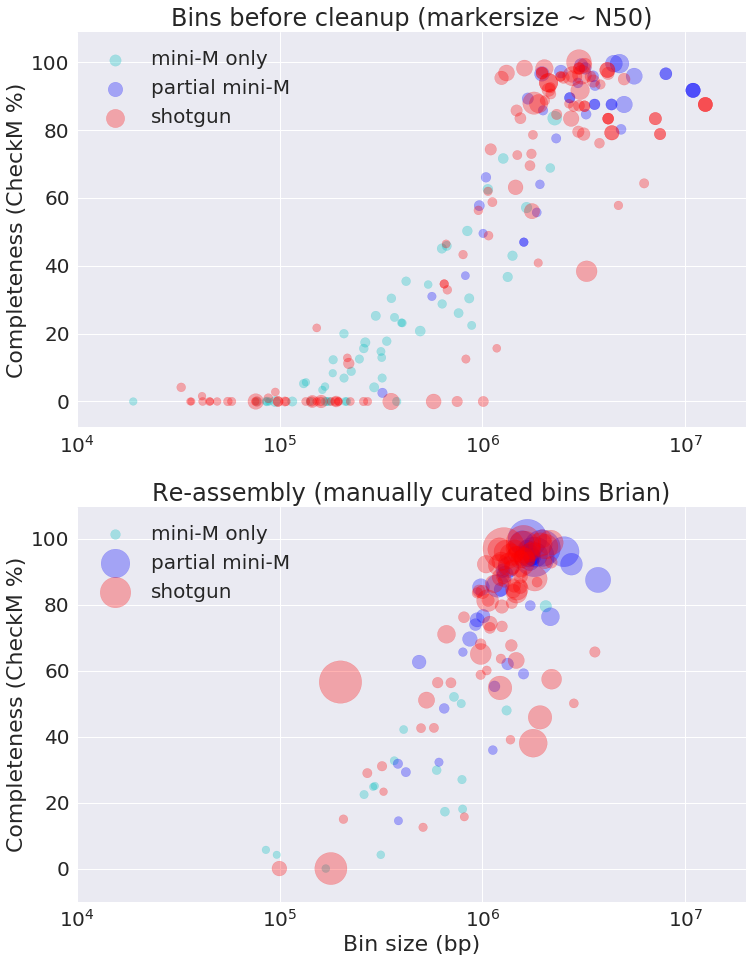

In [28]:
minimix = alt5[alt5['assembly'].str.contains('minim')].index
minipur = alt5[alt5['assembly']=='mini'].index
bulk = alt5[~alt5['assembly'].str.contains('mini')].index



gen_minimix = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(minimix)]
gen_minipur = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(minipur)]
gen_bulk = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(bulk)]


f=plt.figure()
gs = gridspec.GridSpec(2,1)
f.set_figwidth(12)
f.set_figheight(16)

ax1 = f.add_subplot(gs[0,0])
ax1.scatter(gen_minipur['Genome size'].astype(float),gen_minipur['Completeness'],s=gen_minipur['N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='c')
ax1.scatter(gen_minimix['Genome size'].astype(float),gen_minimix['Completeness'],s=gen_minimix['N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='b')
ax1.scatter(gen_bulk['Genome size'].astype(float),gen_bulk['Completeness'],s=gen_bulk['N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='r')
plt.xscale('log')
#plt.xlabel('Bin size (bp)')
plt.xlim(1e4,2e7)
plt.ylabel('Completeness (CheckM %)')
plt.title('Bins before cleanup (markersize ~ N50)')
plt.legend(['mini-M only','partial mini-M','shotgun'])

ax2 = f.add_subplot(gs[1,0])
ax2.scatter(gen_minipur['r_Genome size'].astype(float),gen_minipur['r_Completeness'],s=gen_minipur['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='c')
ax2.scatter(gen_minimix['r_Genome size'].astype(float),gen_minimix['r_Completeness'],s=gen_minimix['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='b')
ax2.scatter(gen_bulk['r_Genome size'].astype(float),gen_bulk['r_Completeness'],s=gen_bulk['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='r')
plt.xscale('log')
plt.xlim(1e4,2e7)
plt.xlabel('Bin size (bp)')
plt.ylabel('Completeness (CheckM %)')
plt.title('Re-assembly (manually curated bins Brian)')
plt.legend(['mini-M only','partial mini-M','shotgun'])
plt.show()
f.savefig('reassembly/reassembled_size_vs_completeness_N50markerSize2')
f.savefig('reassembly/reassembled_size_vs_completeness_N50markerSize2.pdf')

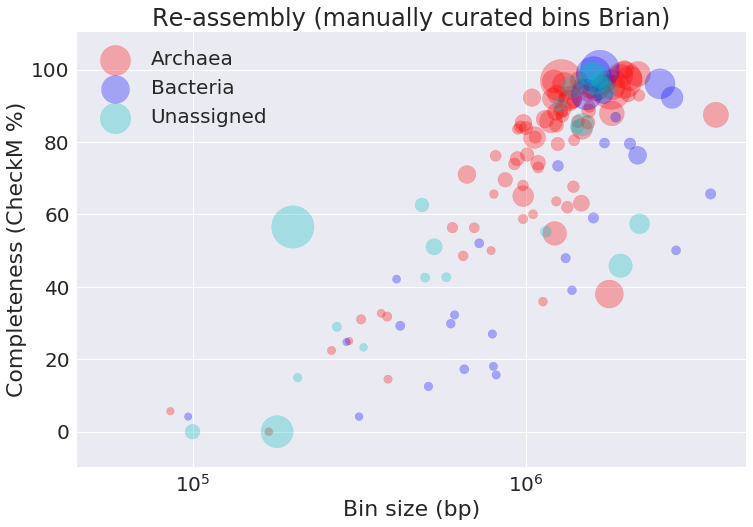

In [189]:
arch = alt5[alt5['domain']=='Archaea'].index
bact = alt5[alt5['domain']=='Bacteria'].index
viru = alt5[alt5['domain']=='Viruses'].index
unas = alt5[alt5['domain']=='Unassigned'].index

gen_arch = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(arch)]
gen_bact = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(bact)]
gen_viru = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(viru)]
gen_unas = Obs_genome_overview[Obs_genome_overview['cluster_old'].isin(unas)]

f=plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.scatter(gen_arch['r_Genome size'].astype(float),gen_arch['r_Completeness'],s=gen_arch['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='r')
plt.scatter(gen_bact['r_Genome size'].astype(float),gen_bact['r_Completeness'],s=gen_bact['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='b')
#plt.scatter(gen_viru['r_Genome size'].astype(float),gen_viru['r_Completeness'],s=gen_viru['r_N50 (contigs)'].multi(0.001).dropna().astype(int), alpha=1,color='m')
plt.scatter(gen_unas['r_Genome size'].astype(float),gen_unas['r_Completeness'],s=gen_unas['r_N50 (contigs)'].divide(100).dropna().astype(int), alpha=0.3,color='c')
plt.xscale('log')
plt.xlabel('Bin size (bp)')
plt.ylabel('Completeness (CheckM %)')
plt.title('Re-assembly (manually curated bins Brian)')
plt.legend(['Archaea','Bacteria','Unassigned'])
plt.show()
f.savefig('reassembly/reassembled_size_vs_completeness_N50markerSize_domains')

In [183]:
alt5.domain.value_counts()

Archaea       85
Bacteria      57
Unassigned    43
Viruses        2
Name: domain, dtype: int64

In [ ]:
def plotshit(df)
    ############################################################################################
    # cluster correlation for KEGG B-level = environmental info processing
    ############################################################################################

    dataC = dataframe.fillna(0).corr().dropna(how='all').T.dropna(how='all')
    clustindexlist = dataC.index

    D = pdist(dataC, 'euclidean')
    Z = linkage(D, 'ward')
    row_link = _optimal_order(dataC, metric='correlation')

    optimal_Z = optimal_leaf_ordering(Z, D)

    cgClust = sns.clustermap(dataC, row_linkage=row_link, col_linkage=row_link,figsize=(20,40))


    ############################################################################################
    # KEGG-clust correlation for KEGG B-level = environmental info processing
    ############################################################################################

    #dataK = alt6.ix[idxblevdf['column'].values,:].T.corr() #np.random.choice(10000, (n, 1), replace=False)
    dataK = dataframe.fillna(0).T.corr()

    dataK = dataK.dropna(how='all').T.dropna(how='all')

    D = pdist(dataK, 'euclidean')
    Z = linkage(D, 'ward')
    row_link = _optimal_order(dataK, metric='correlation')

    optimal_Z = optimal_leaf_ordering(Z, D)

    cgKEGG_blevel = sns.clustermap(dataK, row_linkage=row_link, col_linkage=row_link,figsize=(10,10))
    roundd=0
    # sort by clustermap, 

    idx = cgKEGG_blevel.dendrogram_col.reordered_ind
    idxcl = cgClust.dendrogram_col.reordered_ind
    cmap=ListedColormap(["#e74c3c", "#3498db", "#2ecc71", "#95a5a6", "#34495e","#9b59b6"])
    cmap=ListedColormap(["#e74c3c", "#9b59b6", "#2ecc71", "#95a5a6", "#34495e","#3498db"])#[red,lightblue,green,GREY,darkblue,purple]
    #cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

    f = plt.figure()
    gs = gridspec.GridSpec(45,37)


    dataK2 = dataK.copy()
    dataK2.index = mod_df.set_index('Module').loc[dataK.index]['Module_combined']

    ax1 = f.add_subplot(gs[4:36,0:11])
    sns.heatmap(dataK2.iloc[idx,idx],cbar=False,ax=ax1,xticklabels=True,yticklabels=True,cmap="RdBu_r",vmin=-1,vmax=1)
    plt.xticks([]);plt.yticks(fontsize=15)
    plt.xlabel('KEGG modules',fontsize=30,labelpad=40)

    ###############################################
    ######### the sorter #####################
    ###############################################
    #idx2 = alt.sort_values('assembly').index
    ###############################################
    ###############################################
    # save dataframe in ordered way for future examination
    #clusteredframe = dataframe.loc[dataK.iloc[idx,:].index,dataC.iloc[idxcl,:].index]
    #if roundd == 0:
    #    clusteredframe.to_pickle('ClusteredDF_brian_'+completeness)
    #    roundd=1 #save only once for a loop through B-levels

    ax2 = f.add_subplot(gs[4:36,13:32])
    sns.heatmap(dataframe_col.fillna(0).loc[dataK.iloc[idx,:].index,dataC.iloc[idxcl,:].index]
                ,ax=ax2,cbar=False,linewidth=0.5,cmap=cmap,vmin=-1,vmax=1,xticklabels=True)
    plt.yticks([])
    plt.xlabel('Genome number',fontsize=30)
    #plt.xticks(rotation=0)

    ax13 = f.add_subplot(gs[37:,13:32])
    sns.heatmap(dataC.iloc[idxcl,idxcl],cbar=False,ax=ax13,cmap="RdBu_r",vmin=-1,vmax=1)
    plt.yticks([])
    plt.xticks([])


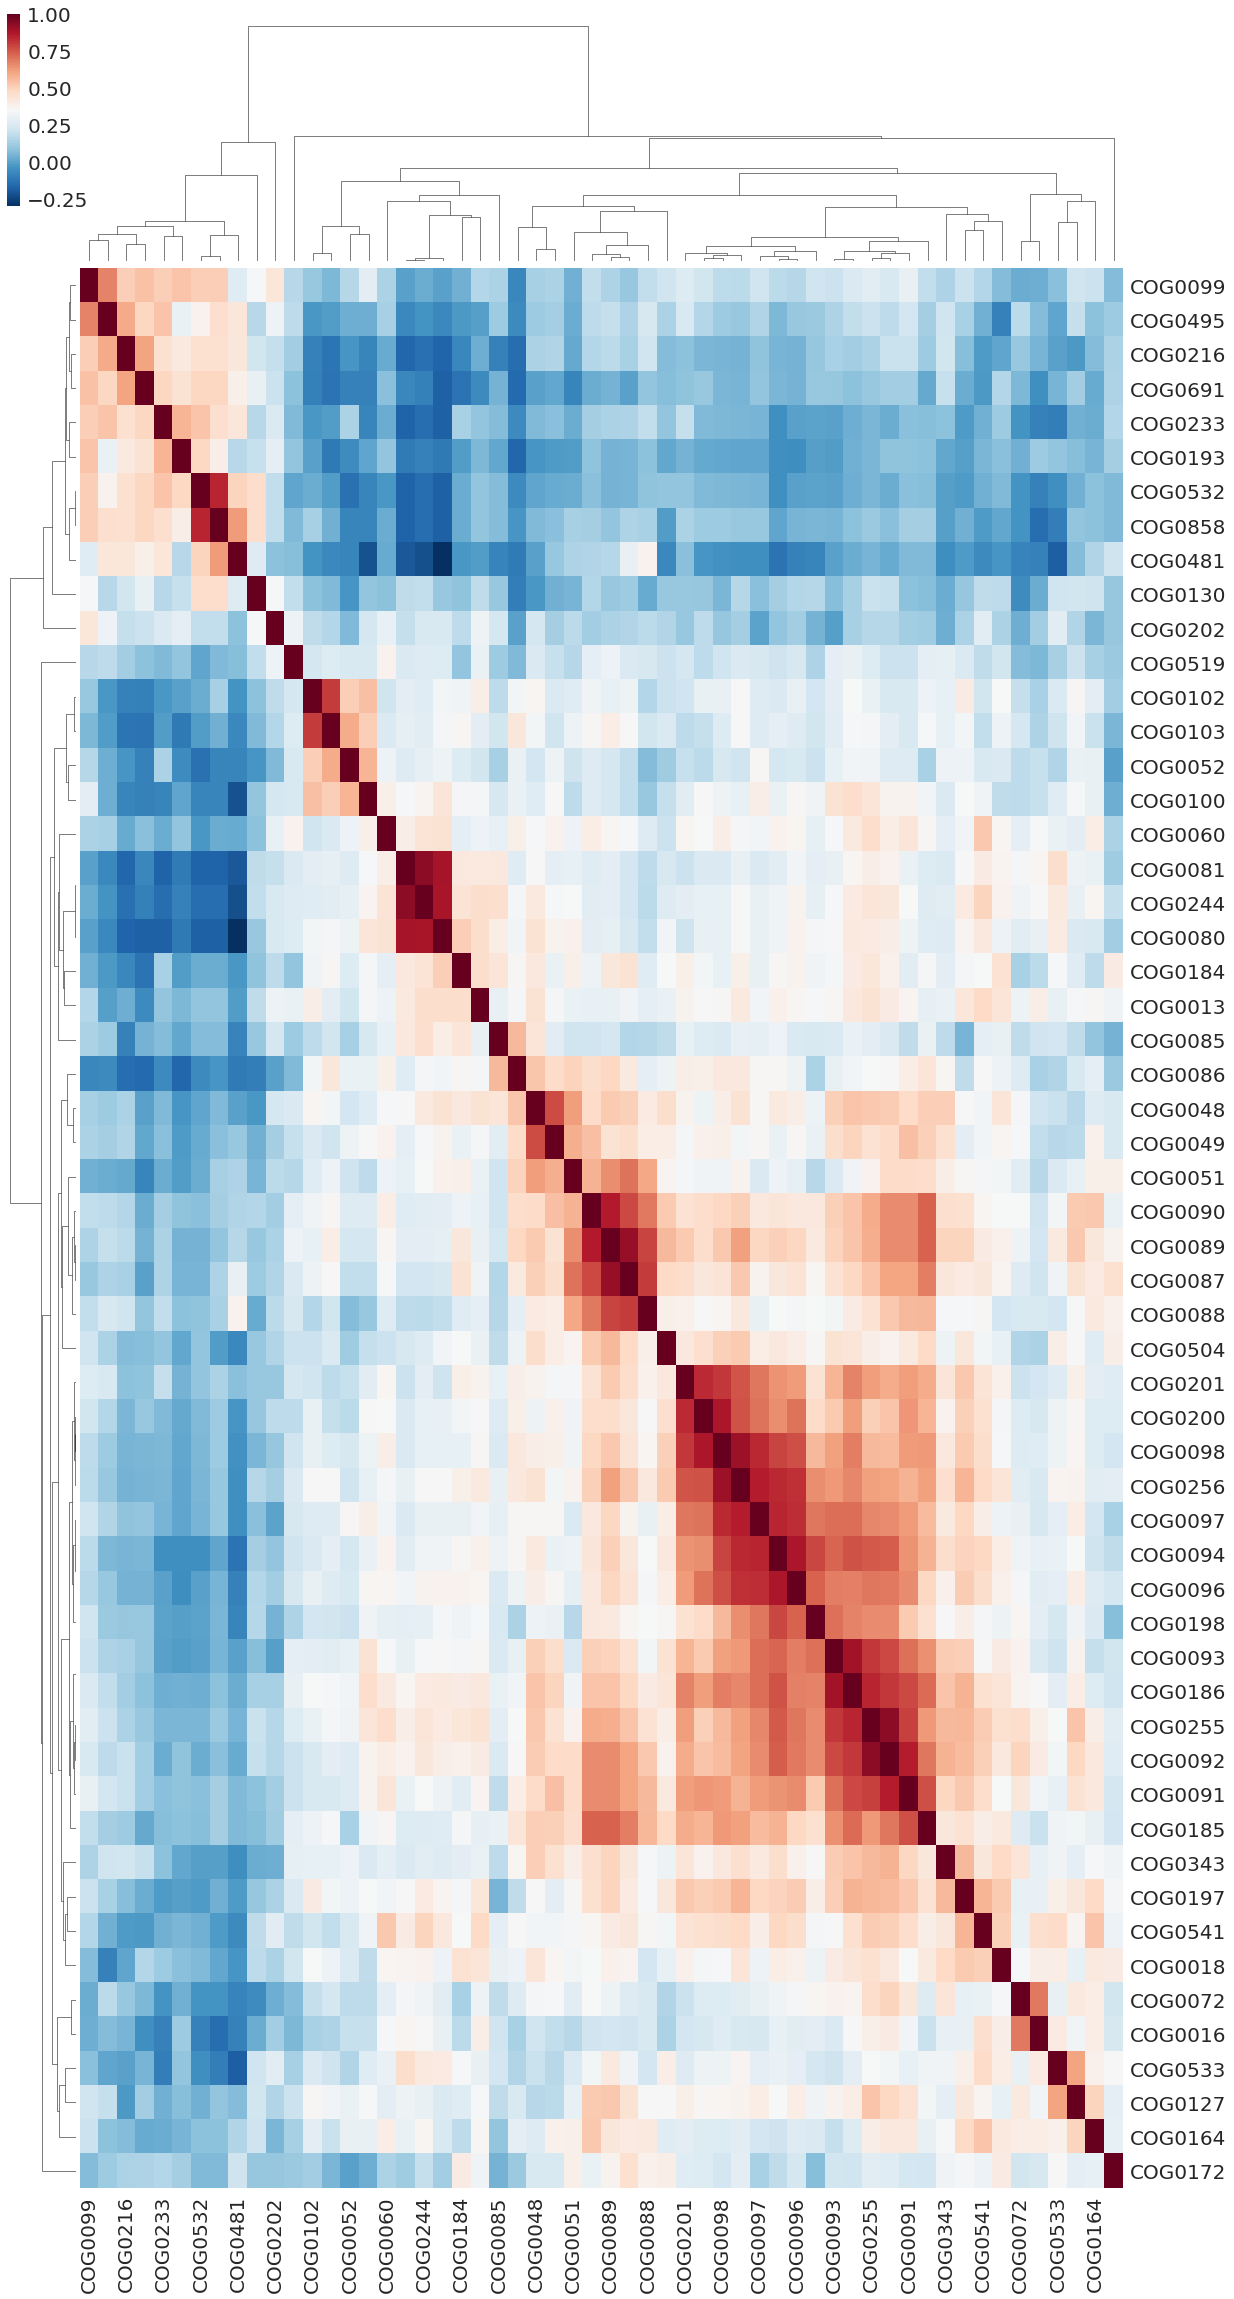

In [762]:
dataB = pd.read_table('Tree_Obsidian/bojan_bins_phylogeny_V1/archaea/56_Hits_ref_query_count.tab')
dataC = dataB[dataB['Unnamed: 0'].str.contains('Obs')].copy()
dataC = dataC.set_index('Unnamed: 0')

dataD = dataC.corr().dropna(how='all').T.dropna(how='all')
clustindexlist = dataD.index

D = pdist(dataD, 'correlation')
Z = linkage(D, 'average')
row_link = _optimal_order(dataD, metric='correlation')

optimal_Z = optimal_leaf_ordering(Z, D)

cgClust = sns.clustermap(dataD, row_linkage=row_link, col_linkage=row_link,figsize=(20,40),cmap='RdBu_r')
plt.show()


In [232]:
dataC.T.sum().sort_values()
dataD

Unnamed: 0,Obs2_genome_000,Obs2_genome_001,Obs2_genome_002,Obs2_genome_003,Obs2_genome_004,Obs2_genome_005,Obs2_genome_006,Obs2_genome_007,Obs2_genome_008,Obs2_genome_009,...,Obs5_genome_011,Obs5_genome_012,Obs5_genome_013,Obs5_genome_014,Obs5_genome_015,Obs5_genome_016,Obs5_genome_017,Obs6_genome_000,Obs6_genome_001,Obs6_genome_002
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Obs2_genome_000,1.000000e+00,-0.044947,-0.037398,-0.170603,0.070418,-1.842265e-01,-0.152758,1.396551e-01,-0.114243,0.161405,...,-0.224387,-0.019253,-0.073922,-3.808775e-02,0.098919,0.022088,-8.883363e-02,3.553345e-02,-0.109755,-1.448414e-01
Obs2_genome_001,-4.494666e-02,1.000000,0.388290,0.571694,0.104447,4.489140e-01,0.320983,2.259731e-01,0.647898,0.354314,...,0.129430,-0.299847,-0.089709,-3.012974e-01,-0.284811,0.163810,-1.054093e-01,-2.108185e-01,0.047880,2.148345e-01
Obs2_genome_002,-3.739788e-02,0.388290,1.000000,0.413294,0.280027,2.652527e-01,0.089025,3.969331e-01,0.384270,0.369173,...,-0.066667,-0.122764,0.312392,3.133683e-02,-0.131654,0.257452,2.777350e-01,-1.315587e-01,0.071710,2.581989e-01
Obs2_genome_003,-1.706027e-01,0.571694,0.413294,1.000000,0.318135,4.417596e-01,0.220311,1.800152e-01,0.497446,0.214047,...,0.168957,-0.279010,0.130317,-1.164804e-01,-0.226887,0.228749,-2.963695e-02,-2.963695e-02,0.138659,3.322166e-01
Obs2_genome_004,7.041788e-02,0.104447,0.280027,0.318135,1.000000,3.567530e-01,0.338543,3.540318e-01,0.345294,0.565106,...,-0.099780,-0.047226,0.140547,-1.048983e-01,-0.130709,0.366901,5.504819e-02,1.834940e-01,0.378404,3.864448e-01
Obs2_genome_005,-1.842265e-01,0.448914,0.265253,0.441760,0.356753,1.000000e+00,0.270867,2.315535e-01,0.796677,0.294376,...,-0.037893,0.146310,-0.061283,1.543690e-01,0.017688,0.111903,-1.080123e-01,-2.160247e-01,0.451377,1.467599e-01
Obs2_genome_006,-1.527578e-01,0.320983,0.089025,0.220311,0.338543,2.708671e-01,1.000000,2.026674e-01,0.324650,0.235956,...,0.057604,-0.359911,0.307712,-9.600034e-02,-0.007333,0.337132,-1.492704e-02,-1.492704e-02,0.084076,2.028185e-01
Obs2_genome_007,1.396551e-01,0.225973,0.396933,0.180015,0.354032,2.315535e-01,0.202667,1.000000e+00,0.292815,0.205574,...,-0.396933,-0.209725,0.259029,-1.914894e-01,-0.185278,0.197422,-2.977457e-02,7.443642e-02,0.281311,-2.022783e-02
Obs2_genome_008,-1.142433e-01,0.647898,0.384270,0.497446,0.345294,7.966772e-01,0.324650,2.928149e-01,1.000000,0.439552,...,0.080171,-0.006405,0.001490,-2.252422e-02,-0.215498,0.275943,-1.260820e-01,-3.467255e-01,0.439552,1.391908e-01


In [168]:
np.array(gen_minipur['r_GC'].dropna())

array([0.534429146333813, 0.43729780768059934, 0.4416897221699929,
       0.4562926094190274, 0.3846826691656603, 0.4285935896517983,
       0.5810060853134159, 0.5198646270624514, 0.28203822526233097,
       0.32720110631521604, 0.4901247955934246, 0.33842672649314415,
       0.47413133114927386, 0.25267747000112145, 0.37455888970466333,
       0.5009791703756453, 0.3913492173015654], dtype=object)

In [244]:
dataG = dataB.set_index('Unnamed: 0')
dataG = dataG[dataG.index.str.contains('Obs')]
dataG.T.sum().sort_values()
hicor = ['Obs2_genome_008','Obs2_genome_028','Obs3_genome_011','Obs4_genome_020']
dataF[dataF['Unnamed: 0'].isin(hicor)]

,Unnamed: 0,total,domain,phylum,species
59,Obs3_genome_011,45,Archaea,Crenarchaeota,Sulfolobales archaeon Acd1
71,Obs4_genome_020,44,Unassigned,Unassigned,Unassigned
89,Obs2_genome_028,43,Archaea,Crenarchaeota,Metallosphaera sedula
90,Obs2_genome_008,43,Unassigned,Unassigned,Unassigned


In [559]:
obs4_contigs = pd.read_pickle('maindfs_withclusters/Obsidian4clusterContigRelation')
obs4_a = obs4_contigs[obs4_contigs['Genome ID'].str.contains('meta')]
obs4_a = obs4_a[obs4_a['DBclusternum']==17]
obs4_b = obs4_contigs[obs4_contigs['Genome ID'].str.contains('mega')]
obs4_b = obs4_b[obs4_b['DBclusternum']==11]
obs4_vir = obs4_a.append(obs4_b)
print(str(len(obs4_a))+' + '+str(len(obs4_b))+' should be '+str(len(obs4_vir)))

84 + 19 should be 103


In [596]:
len(pfam_vir_hmm[3])#.unique())
len(pfam_hmm[0][-6:-1])
pfam_hmm[0].str[10:15]

0        10001
1        10001
2        10001
3        10001
4        10001
5        10001
6        10001
7        10001
8        10001
9        10002
10       10002
11       10002
12       10002
13       10002
14       10004
15       10004
16       10004
17       10004
18       10004
19       10004
20       10004
21       10004
22       10004
23       10005
24       10005
25       10005
26       10005
27       10005
28       10005
29       10005
         ...  
63208    14924
63209    14924
63210    14925
63211    14925
63212    14925
63213    14925
63214    14925
63215    14925
63216    14926
63217    14926
63218    14926
63219    14927
63220    14927
63221    14927
63222    14927
63223    14927
63224    14929
63225    14929
63226    14929
63227    14929
63228    14929
63229    14930
63230    14931
63231    14931
63232    14931
63233    14931
63234    14931
63235    14931
63236    14931
63237    14931
Name: 0, Length: 63238, dtype: object

In [603]:
pfam = pd.read_table('../../datastorage/Obsidian_annotationData_5kb/Obs4/IMGData/127877.assembled.Pfam.blout',header=None)
pfam_hmm = pd.read_table('../../datastorage/Obsidian_annotationData_5kb/Obs4/IMGData/127877.assembled.unsorted.Pfam.hmmout',header=None)
obs4_vir
pfam_vir = pfam[pfam[0].str[10:15].isin(obs4_vir['Scaffold Name'].astype(str))]
pfam_vir_hmm = pfam_hmm[pfam_hmm[0].str[10:15].isin(obs4_vir['Scaffold Name'].astype(str))]
pfam_vir_hmm[3].value_counts()

Glycos_transf_1    37
RHH_1              17
ResIII             15
Helicase_C         13
DSPc               11
DUF1874            10
AAA                 6
Laminin_G_3         6
AAA_21              4
Thy1                4
GDP_Man_Dehyd       4
AAA_5               4
AAA_31              3
TFIIB               3
Lon_2               3
ParBc               3
ERCC3_RAD25_C       3
dUTPase             3
DEAD                2
Epimerase           2
Sulfolobus_pRN      2
Phage_integrase     2
OrfB_Zn_ribbon      2
PDDEXK_1            2
Phage_int_SAM_4     1
DUF2079             1
Cas_Cas4            1
Methyltransf_21     1
DUF2813             1
HTH_3               1
MCM                 1
PAPS_reduct         1
RHH_3               1
DUF2341             1
DUF4214             1
HD                  1
GATase_4            1
NAD_binding_8       1
MethyltransfD12     1
PolyA_pol           1
Y1_Tnp              1
Acyl_transf_3       1
DUF2201_N           1
PLDc_2              1
N6_N4_Mtase         1
Glycos_tra

In [600]:
pfam_vir_hmm[3].value_counts()
pfam_vir_hmm[4].value_counts()
pfam_vir_hmm
#assemb_fna = pd.read_table('../../datastorage/Obsidian_annotationData_5kb/Obs4/IMGData/127877.assembled.fna')
output_file = 'fasta/Obsidian4_M51_faa/M51_pfamhits.faa'
input_file = '../../datastorage/Obsidian_annotationData_5kb/Obs4/IMGData/127877.assembled.faa'


with open(output_file, 'w') as out_file:
        j=0
        for s in HTSeq.FastaReader( input_file ):
            if pfam_vir_hmm[0].str[10:].str.contains(s.name[10:]).any():
                #name = name.lower()
                #SeqIO.write(sequence,out_file,"fasta")
                s.write_to_fasta_file(out_file)
                j+=1
                print(s.name+' is in file count is '+str(j))
            #else:
                #print(s.name+' is not in file')
        out_file.close()

Ga0187308_101195 is in file count is 1
Ga0187308_101197 is in file count is 2
Ga0187308_101198 is in file count is 3
Ga0187308_104817 is in file count is 4
Ga0187308_106331 is in file count is 5
Ga0187308_106332 is in file count is 6
Ga0187308_106334 is in file count is 7
Ga0187308_1063315 is in file count is 8
Ga0187308_1063320 is in file count is 9
Ga0187308_106951 is in file count is 10
Ga0187308_106956 is in file count is 11
Ga0187308_1069517 is in file count is 12
Ga0187308_1069519 is in file count is 13
Ga0187308_107241 is in file count is 14
Ga0187308_1072412 is in file count is 15
Ga0187308_112582 is in file count is 16
Ga0187308_112585 is in file count is 17
Ga0187308_114201 is in file count is 18
Ga0187308_116501 is in file count is 19
Ga0187308_1165010 is in file count is 20
Ga0187308_117521 is in file count is 21
Ga0187308_117523 is in file count is 22
Ga0187308_1175230 is in file count is 23
Ga0187308_1175234 is in file count is 24
Ga0187308_1175235 is in file count is 25


Ga0187308_143773 is in file count is 203
Ga0187308_143993 is in file count is 204
Ga0187308_144461 is in file count is 205
Ga0187308_1444610 is in file count is 206
Ga0187308_144532 is in file count is 207
Ga0187308_144536 is in file count is 208
Ga0187308_145581 is in file count is 209
Ga0187308_1455816 is in file count is 210
Ga0187308_146001 is in file count is 211
Ga0187308_1460010 is in file count is 212
Ga0187308_1460012 is in file count is 213
Ga0187308_146071 is in file count is 214
Ga0187308_146072 is in file count is 215
Ga0187308_146075 is in file count is 216
Ga0187308_146426 is in file count is 217
Ga0187308_147606 is in file count is 218


In [575]:
input_file = 'fasta/Obsidian4_M51_faa/M51_pfamhits.fasta'
sequences = dict( (s.name, s) for s in HTSeq.FastaReader(input_file) )
len(sequences)
sequences
pfam_vir_hmm[0].value_counts()
s.name[10:]
input_file


<module 'HTSeq' from '/usr/lib/python3.6/site-packages/HTSeq/__init__.py'>

In [1029]:
list(pfam_vir_hmm[3].value_counts().index)
crisp_clusters

meta_6     7
mega_18    3
meta_18    3
meta_19    2
mega_7     2
meta_9     1
meta_4     1
mini_3     1
mega_16    1
mega_14    1
meta_17    1
meta_13    1
meta_12    1
meta_11    1
meta_20    1
meta_0     1
Name: cluster, dtype: int64

In [612]:
pfam_vir_hmm[pfam_vir_hmm[3]=='Phage_int_SAM_4']
#pfam_vir_hmm[pfam_vir_hmm[0].str.contains('11329')]
pfam_vir_hmm[pfam_vir_hmm[0].str.contains('12656')]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
46542,Ga0187308_1265610,-,305,MCM,PF00493.21,331,1.100000e-08,36.5,0.4,1,...,28.0,0.4,58,172,115,212,82,216,0.83,-
46543,Ga0187308_1265612,-,299,AAA_21,PF13304.4,303,1.400000e-14,56.6,2.0,1,...,37.3,0.1,183,297,137,251,135,257,0.83,-
46544,Ga0187308_1265612,-,299,DUF2813,PF11398.6,372,4.000000e-07,31.6,0.2,1,...,21.3,0.1,1,44,1,43,1,68,0.84,-
46545,Ga0187308_1265618,-,513,AAA,PF00004.27,132,4.700000e-36,126.1,0.0,1,...,121.1,0.0,1,130,279,404,279,406,0.96,-
46546,Ga0187308_126562,-,294,UbiA,PF01040.16,252,2.100000e-31,111.1,19.0,1,...,110.7,19.0,2,228,54,266,53,291,0.80,-
46547,Ga0187308_126568,-,354,AAA_21,PF13304.4,303,8.900000e-28,99.9,3.3,2,...,65.8,0.4,193,303,202,309,186,309,0.80,-
46548,Ga0187308_126568,-,354,AAA_15,PF13175.4,384,5.400000e-21,77.6,3.9,1,...,57.1,0.9,1,109,1,107,1,145,0.73,-
46549,Ga0187308_126569,-,288,Phage_integrase,PF00589.20,172,7.900000e-31,109.1,0.1,1,...,102.7,0.1,3,170,105,265,103,267,0.97,-
46550,Ga0187308_126569,-,288,Phage_int_SAM_4,PF13495.4,85,5.300000e-09,38.3,0.7,1,...,37.0,0.1,12,77,19,82,10,90,0.88,-


In [303]:
156/579

0.2694300518134715

In [607]:
pfam_vir_unique = pd.DataFrame(index=pfam_vir_hmm[3].value_counts().index,columns=['pfam','hits'])
pfam_vir_unique['hits'] = pfam_vir_hmm[3].value_counts()
pfam_vir_unique['pfam'] = [pfam_vir_hmm[pfam_vir_hmm[3]==s].iloc[0,4] for s in pfam_vir_unique.index]
pfam_vir_unique.to_csv('fasta/Obsidian4_M51_faa/pfam_vir_names.txt','\t')
len(pfam_vir_unique)

57

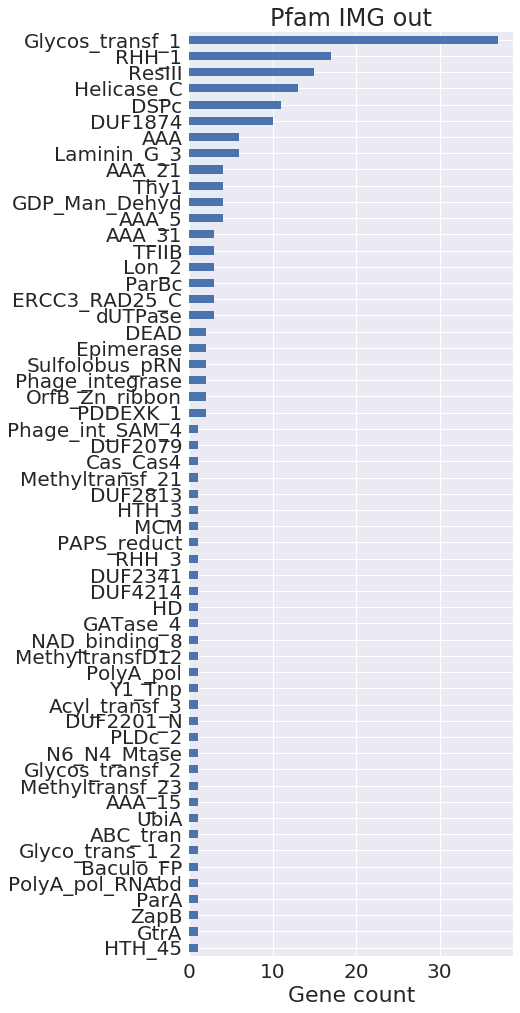

In [606]:
#[pfam_vir_hmm[4]==s].iloc[0,4]

f = plt.figure()
f.set_figheight(17)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left=0.6)
pfam_vir_hmm[3].value_counts().plot.barh()
plt.gca().invert_yaxis()
plt.title('Pfam IMG out')
plt.xlabel('Gene count')
plt.show()
f.savefig('Individual_bins_obs/M51_viral_cluster/pfamout_IMG_barh')

In [320]:
Obs_genome_overview[Obs_genome_overview['cluster_old']=='M51']['name_brian']

numidx
344    genome_cluster_051
Name: name_brian, dtype: object

In [324]:
expt_name = 'Obsidian4'
COGassembly = pd.read_pickle(expt_name+'_COGassembly_All')

In [1201]:
#isin(COGassembly[COGassembly['name'].str.contains('Cas')]['contig'].str[0:5])
obs4_vir['Scaffold Name'].astype(str)
# all cog genes containing 'Cas' and being part of M51
list(COGassembly[(COGassembly['contig'].str[0:5].isin(COGassembly[COGassembly['name'].str.contains('Cas')]['contig'].str[0:5])) & COGassembly['contig'].str[0:5].isin(obs4_vir['Scaffold Name'].astype(str))]['name'])
# all cog genes containing 'Cas' and being part of M49 (or obs4_meta_6 to start off with)
a = COGassembly[(COGassembly['contig'].str[0:5].isin(COGassembly[COGassembly['name'].str.contains('CRISPR')]['contig'].str[0:5])) & COGassembly['contig'].str[0:5].isin(obs4_contigs[(obs4_contigs['Genome ID'].str.contains('meta')) & (obs4_contigs['DBclusternum']==6)]['Scaffold Name'].astype(str))]
len(a) #54
a['name'].astype(list)

30900                                          Transposase
30901    Glucoamylase (glucan-1,4-alpha-glucosidase), G...
30902    Pyruvate/2-oxoglutarate dehydrogenase complex,...
30903                               Amino acid transporter
30904    Predicted enzyme related to lactoylglutathione...
30905    Predicted metal-dependent hydrolase, TIM-barre...
30906        Zn-dependent protease with chaperone function
30907    B3/B4 domain (DNA/RNA-binding domain of Phe-tR...
30908                          Ketol-acid reductoisomerase
30909    Glycogen debranching enzyme (alpha-1,6-glucosi...
30910    Glycogen debranching enzyme (alpha-1,6-glucosi...
30911        Sugar-specific transcriptional regulator TrmB
30912                                          Transposase
30913    Predicted ATPase, archaeal AAA+ ATPase superfa...
30914    Peptidoglycan/xylan/chitin deacetylase, PgdA/C...
30915    CRISPR/Cas system endoribonuclease Cas6, RAMP ...
30916           Glycine/D-amino acid oxidase (deaminatin

In [327]:
COGassembly['Gene_name'] = COGassembly['assembly']+'_'+COGassembly['contig']

In [1194]:
COG_vir = COGassembly[COGassembly['Gene_name'].isin(pfam_vir_hmm[0])]
COG_vir
list(obs4_contigs[(obs4_contigs['Genome ID'].str.contains('meta')) & (obs4_contigs['DBclusternum']==6)]['Scaffold Name'])

[12028,
 12037,
 12041,
 12047,
 12063,
 12086,
 12089,
 12110,
 12115,
 12134,
 12139,
 12141,
 12143,
 12171,
 12179,
 12195,
 12202,
 12215,
 12219,
 12229,
 12238,
 12243,
 12348,
 12356,
 12372,
 12392,
 12436,
 12477,
 12480,
 12485,
 12506,
 12521,
 12523,
 12542,
 12558,
 12564,
 12569,
 12607,
 12625,
 12695,
 12701,
 12711,
 12727,
 12732,
 12744,
 12787,
 12816,
 12828,
 12869,
 12889,
 12912,
 12913,
 12940,
 12946,
 12949,
 12998,
 13001,
 13022,
 13031,
 13063,
 13086,
 13097,
 13101,
 13146,
 13168,
 13267,
 13343,
 13371,
 13388,
 13397,
 13408,
 13446,
 13447,
 13457,
 13466,
 13502,
 13550,
 13610,
 13612,
 13660,
 13683,
 13701,
 13705,
 13746,
 13758,
 13766,
 13773,
 13837,
 13867,
 13874,
 13876,
 13890,
 13899,
 13919,
 13973,
 14013,
 14017,
 14030,
 14054,
 14056,
 14072,
 14113,
 14315,
 14345,
 14415,
 14447,
 14507,
 14519,
 14618,
 14679,
 14686,
 14699]

In [418]:
f = plt.figure()
f.set_figheight(23)
f.set_figwidth(18)
COG_vir['name'].value_counts().plot.barh()
plt.gca().invert_yaxis()
#plt.show()
plt.title('COG names')
plt.xlabel('Gene count')
plt.gcf().subplots_adjust(left=0.85)
f.savefig('Individual_bins_obs/M51_viral_cluster/COGnames')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [417]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
COG_vir['cluster0'].value_counts().plot.barh()
plt.gca().invert_yaxis()
#plt.show()
plt.title('COG category')
plt.xlabel('Gene count')
plt.gcf().subplots_adjust(left=0.6)
f.savefig('Individual_bins_obs/M51_viral_cluster/COGcat')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [416]:
COG_vir[COG_vir['Gene_name']=='Ga0187308_132143'] # empty result implies the Cas4 gene does not show up here
pfamhits_vir = pd.read_table('Individual_bins_obs/M51_viral_cluster/PfamHmmOut.csv')
pfamhits_vir = pfamhits_vir[1:]
f = plt.figure()
f.set_figheight(17)
f.set_figwidth(15)
plt.gcf().subplots_adjust(left=0.6)
pfamhits_vir['Unnamed: 5'].value_counts().plot.barh()
plt.gca().invert_yaxis()
plt.title('Pfam blast out')
plt.xlabel('Gene count')
#plt.show()
f.savefig('Individual_bins_obs/M51_viral_cluster/pfamout_barh')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [1027]:
pfam_vir_hmm[pfam_vir_hmm[3].str.contains('ter')]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22


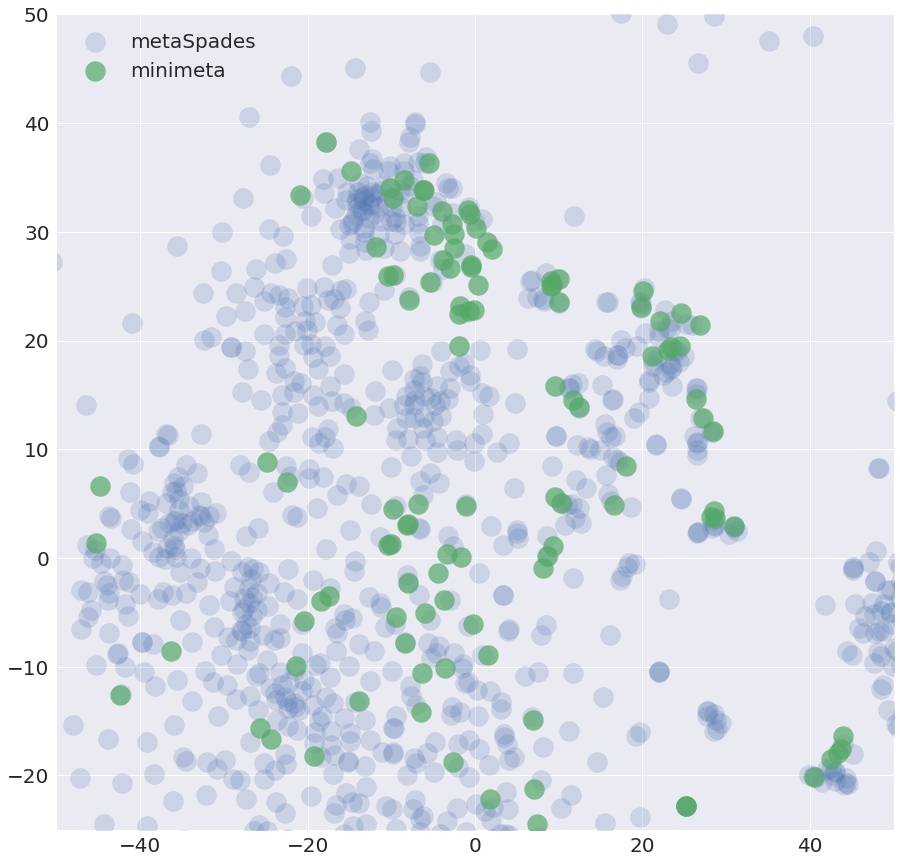

In [4]:
#extract mm viral cluster hits from obsidian 4 
#total length minimeta contigs obs4: 1.2 MB (obs4maindf[obs4maindf['Genome ID']=='minimetagenomics']['Sequence Length'].sum()))

contigor_obs4 = pd.read_pickle('maindfs_withclusters/Obsidian4_minimeta_HDB_maindf')
mScontigor_obs4 = pd.read_pickle('maindfs_withclusters/Obsidian4_metaSpades_HDB_maindf')
mhcontigor_obs4 = pd.read_pickle('maindfs_withclusters/Obsidian4_megahit_HDB_maindf')
obs4maindf = pd.read_pickle('Obsidian4minimeta_maindf')

f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.scatter(mScontigor_obs4['k5_x'],mScontigor_obs4['k5_y'],alpha=0.2,s=400)
plt.scatter(contigor_obs4['k5_x'],contigor_obs4['k5_y'],alpha=0.7,s=400)
plt.xlim(-50,50);plt.ylim(-25,50)
plt.xlabel('');plt.ylabel('')
plt.legend(['metaSpades','minimeta'])
plt.show()
#f.clf()
#f.savefig('Individual_bins_obs/M51_viral_cluster/tSNE_mini-metaS')

In [581]:
contigor_tot[contigor_tot['Scaffold Name']==11329]

,Scaffold ID,Scaffold Name,Genome ID,Genome,Gene Count,Sequence Length,GC Content,Read Depth,Lineage Domain,Lineage Phylum,...,H01,H02,H03,H04,H05,H07,H08,H09,H10,H11
1328,3300017469 assembled Ga0187308,11329,megahit,Hotspring sediment microbial communities from ...,79,66984,0.33,1,Archaea,Crenarchaeota,...,0,0,0,0,0.0018064,0,0,0,0,0


In [542]:
lut

{'Archaea': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'Bacteria': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'Eukaryota': (0.8, 0.7254901960784313, 0.4549019607843137),
 'Unassigned': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'Viruses': (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)}

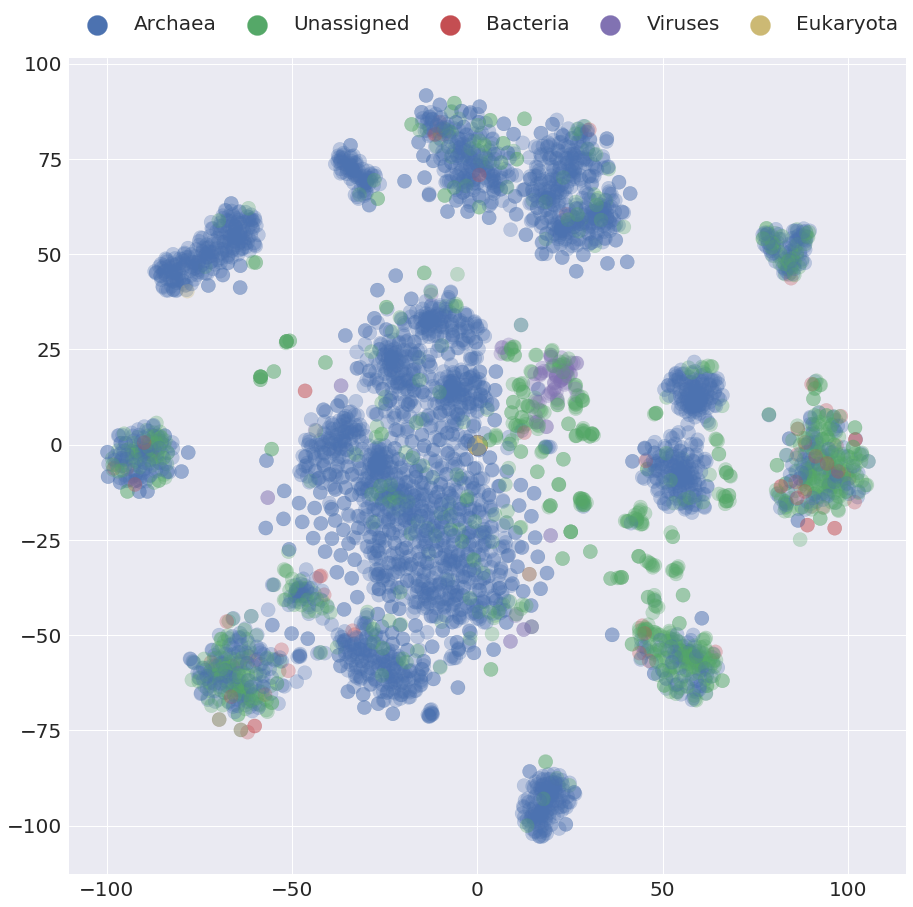

In [6]:
# plot localized obs4 tSNE region colored by phylogeny
contigor_tot  = mhcontigor_obs4.append([mScontigor_obs4,contigor_obs4])
col  = sns.color_palette('deep',len(contigor_tot['Lineage Domain'].unique()))
keys = list(contigor_tot['Lineage Domain'].unique())
values = [i for i in col]
lut = dict(zip(keys,values))
color = contigor_tot['Lineage Domain'].map(lut)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
for x,y in lut.items():
    plt.scatter(0,0,color=y,label=x,s=400)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=5, mode="expand", borderaxespad=0.,fontsize=20)

plt.scatter(contigor_tot['k5_x'],contigor_tot['k5_y'],color=color,s=200,alpha=0.3)
#plt.xlim(-50,50);plt.ylim(-25,50)
plt.xlabel('');plt.ylabel('')
plt.show()
f.savefig('Individual_bins_obs/M51_viral_cluster/phylo-tSNE_tot.pdf')
#f.clf()

In [540]:
f = plt.figure()
f.clf()
f.set_figheight(15)
f.set_figwidth(15)
plt.scatter(mScontigor_obs4[mScontigor_obs4['DBclusternum']!=17]['k5_x'],mScontigor_obs4[mScontigor_obs4['DBclusternum']!=17]['k5_y'],alpha=0.2,s=400,color = [0.5,0.5,0.5])#######
plt.scatter(mScontigor_obs4[mScontigor_obs4['DBclusternum']==17]['k5_x'],mScontigor_obs4[mScontigor_obs4['DBclusternum']==17]['k5_y'],alpha=0.7,s=400)
plt.scatter(contigor_obs4[contigor_obs4['DBclusternum']!=3]['k5_x'],contigor_obs4[contigor_obs4['DBclusternum']!=3]['k5_y'],alpha=0.2,s=400, color=[0.5,0.5,0.5])
plt.scatter(contigor_obs4[contigor_obs4['DBclusternum']==3]['k5_x'],contigor_obs4[contigor_obs4['DBclusternum']==3]['k5_y'],alpha=0.7,s=400)
plt.scatter(mScontigor_obs4[mScontigor_obs4['Scaffold Name']==13214]['k5_x'],mScontigor_obs4[mScontigor_obs4['Scaffold Name']==13214]['k5_y'],color='m',s=400,alpha=0.6)
plt.xlim(-50,50);plt.ylim(-25,50)
plt.xlabel('');plt.ylabel('')
#plt.legend(['other','metaSpades-vir','minimeta_3'])
#plt.show()
f.savefig('Individual_bins_obs/M51_viral_cluster/tSNE_mini3-metaS17.png')

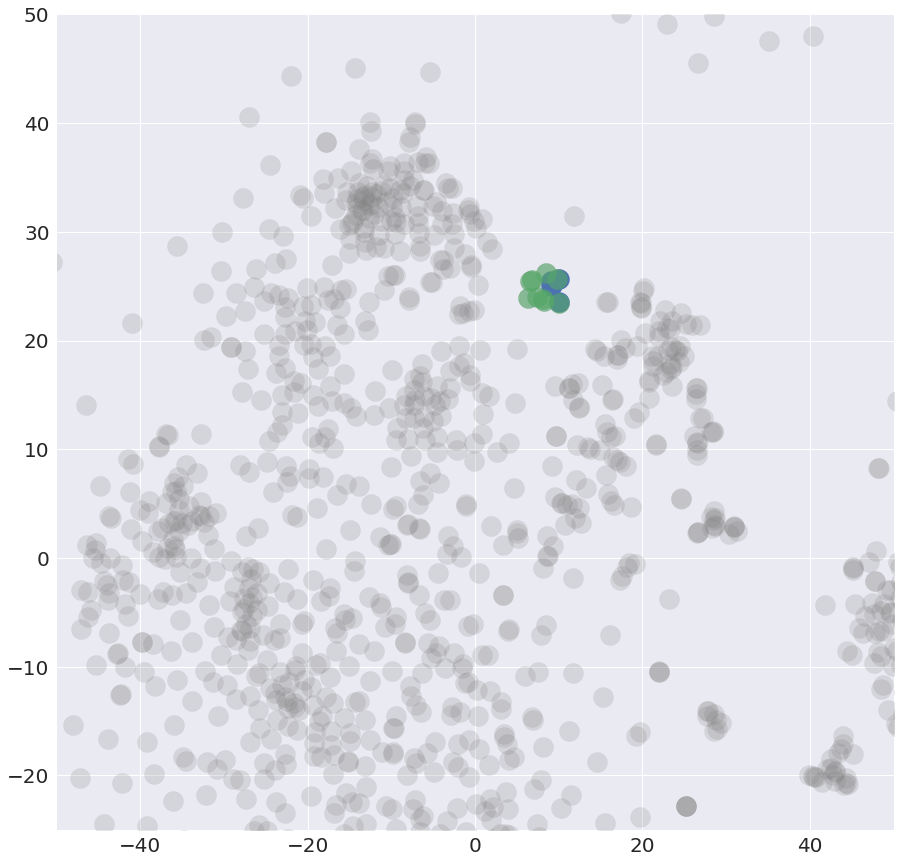

In [764]:
# bsed on the above fig, obs4 mini3 can be split up into multiple groups
obs4_mini_3_sel = contigor_obs4[contigor_obs4['DBclusternum']==3]
obs4_mini_3_sel = obs4_mini_3_sel[obs4_mini_3_sel['k5_x']>15]
obs4_mini_3_sel = obs4_mini_3_sel[obs4_mini_3_sel['k5_y']>15]

obs4_mini_new = contigor_obs4[(contigor_obs4['k5_x']>5) & (contigor_obs4['k5_x']<15) &(contigor_obs4['k5_y']>22) & (contigor_obs4['k5_y']<28)]
obs4_meta_new = mScontigor_obs4[(mScontigor_obs4['k5_x']>5) & (mScontigor_obs4['k5_x']<15) &(mScontigor_obs4['k5_y']>22) & (mScontigor_obs4['k5_y']<28)]
obs4_virusClust_new = obs4_mini_new.append(obs4_meta_new)
obs4_virusClust_new.to_pickle('Individual_bins_obs/New_viral_clust_obs4/new_virus_cluster')


f = plt.figure()
f.clf()
f.set_figheight(15)
f.set_figwidth(15)
plt.scatter(mScontigor_obs4['k5_x'],mScontigor_obs4['k5_y'],alpha=0.2,s=400,color=[0.5,0.5,0.5])
plt.scatter(contigor_obs4['k5_x'],contigor_obs4['k5_y'],alpha=0.2,s=400,color=[0.5,0.5,0.5])
plt.scatter(obs4_mini_new['k5_x'],obs4_mini_new['k5_y'],alpha=0.99,s=400)
plt.scatter(obs4_meta_new['k5_x'],obs4_meta_new['k5_y'],alpha=0.6,s=400)

plt.xlim(-50,50);plt.ylim(-25,50)
plt.xlabel('');plt.ylabel('')
plt.show()
f.savefig('Individual_bins_obs/New_viral_clust_obs4/tSNE_mini-metaS_newclust.png')

In [765]:
# make new virus cluster fasta 
temp = obs4_virusClust_new.copy()
Obs = "Obsidian4"
input_file = 'fasta/'+Obs+'.assembled.fna'
output_file = 'fasta/Obsidian4_new_virus_cluster/Obs4_NewVir.fasta'

temp['Scaffold Name'] = temp['Scaffold Name'].astype(str)
fasta_sequences = SeqIO.parse(open(input_file),'fasta') #this is the fna file from first IMG annotation

with open(output_file, 'w') as out_file:
    for s in HTSeq.FastaReader( input_file ):
        if temp['Scaffold Name'].str.contains(s.name[10:]).any():
            #name = name.lower()
            #SeqIO.write(sequence,out_file,"fasta")
            s.write_to_fasta_file(out_file)
    out_file.close()


In [1089]:
# load crisprs obsidian 
obs2_contigs = pd.read_pickle('maindfs_withclusters/Obsidian2clusterContigRelation')
obs3_contigs = pd.read_pickle('maindfs_withclusters/Obsidian3clusterContigRelation')
obs4_contigs = pd.read_pickle('maindfs_withclusters/Obsidian4clusterContigRelation')
obs5_contigs = pd.read_pickle('maindfs_withclusters/Obsidian5clusterContigRelation')
obs6_contigs = pd.read_pickle('maindfs_withclusters/Obsidian6clusterContigRelation')
o2crisp = pd.read_csv('../../datastorage/Obsidian_annotationData_5kb/Obs2/IMGData/127875.assembled.crisprs',header=None)########
o3crisp = pd.read_csv('../../datastorage/Obsidian_annotationData_5kb/Obs3/IMGData/127876.assembled.crisprs',header=None)
o4crisp = pd.read_csv('../../datastorage/Obsidian_annotationData_5kb/Obs4/IMGData/127877.assembled.crisprs',header=None)
o5crisp = pd.read_csv('../../datastorage/Obsidian_annotationData_5kb/Obs5/IMGData/127878.assembled.crisprs',header=None)
o6crisp = pd.read_csv('../../datastorage/Obsidian_annotationData_5kb/Obs6/IMGData/129678.assembled.crisprs',header=None)

"""o4crisp[1].value_counts().plot.barh() # number of repeats for a given CRISPR region (viral load?)
plt.xlabel('# of repeats')
plt.show()"""
crisp_contigs = obs4_contigs[obs4_contigs['Scaffold Name'].isin(o4crisp[1].unique())]
crisp_contigs['cluster'] = crisp_contigs['Genome ID'].str[0:4]+'_'+crisp_contigs['DBclusternum'].astype(str)
crisp_contigs = crisp_contigs.set_index('Scaffold Name',drop=False) 
crisp_contigs['spacerCount'] = o4crisp[1].value_counts() # add number of repeats per contig
crisp_contigs = crisp_contigs.sort_values('spacerCount',ascending=False)
cc_nouncl = crisp_contigs[crisp_contigs['DBclusternum']>-1]

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1037]:
o4crisp

output_file = 'fasta/Obsidian4_Crispr_spacers.fasta'
i=0
with open(output_file, 'w') as out_file:
    for s in o4crisp[5].dropna():
        byteseq = str.encode(s)
        myseq = HTSeq.Sequence( byteseq, "spacer_"+str(i) )
        i+=1
            #name = name.lower()
            #SeqIO.write(sequence,out_file,"fasta")
        myseq.write_to_fasta_file(out_file)
    out_file.close()

In [1081]:
o4crisp[5]

s
len(o2crisp[5].unique())
# locate duplicate spacers (might be mini-meta-mega redundancy, but also different species
# fending off the same phage)
cols = ['contig0','contig1','contig2','contig3','repeat','sample']
o2true_duplicates = pd.DataFrame(columns=cols)
o2spacer_duplicate = o2crisp[o2crisp.duplicated(5)].dropna()
for sp in o2spacer_duplicate[5]:
    if len(o2crisp[o2crisp[5]==sp][1].unique())>1:
        temp = o2crisp[o2crisp[5]==sp][1].unique()
        temp1 = o2crisp[o2crisp[5]==sp]
        temp2 = pd.DataFrame(index=[sp],columns=cols)
        
        for i in range(0,len(temp)):
            o2true_duplicates.loc[sp,'contig'+str(i)] = temp[i]
        o2true_duplicates.loc[sp,'repeat'] = temp1[4].unique()
        o2true_duplicates.loc[sp,'sample'] = temp1[0].unique()
        

In [1103]:
o2crisp[o2crisp[5]==o2spacer_duplicate.iloc[4,5]][1].unique()
o2true_duplicates['contigpairs'] = o2true_duplicates['contig0'].astype(str)+'_'+o2true_duplicates['contig1'].astype(str)
o2true_duplicates['contigpairs'].unique()
i =9
obs2_contigs[(obs2_contigs['Scaffold Name']==int(o2true_duplicates['contigpairs'].unique()[i][0:5])) ^ (obs2_contigs['Scaffold Name']==int(o2true_duplicates['contigpairs'].unique()[i][6:]))]
#o2true_duplicates['contigpairs'].unique()[0][0:5]

IndexError: index 9 is out of bounds for axis 0 with size 9

In [876]:
crisp_clusters = crisp_contigs[crisp_contigs['DBclusternum']!=-1]['cluster'].value_counts()
#o4crisp
crisp_contigs['DBclusternum'].value_counts() # clusters with CRISPR regions (plus)
len(o4crisp[1].value_counts()) # = 42 contigs containing CRISPR
o4crisp[4].value_counts().sum() # sum = 1960 
#o4crisp[1].value_counts().sum()
crisp_contigs['cluster'].value_counts()
#o4crisp[1].value_counts().plot.barh()

"""crisp_contigs['spacerCount'].plot.barh()
plt.gca().invert_yaxis()
plt.show()
"""
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(15)
plt.title('Bin-associated CRISPRs Obsidian 4')
cc_nouncl.set_index('cluster')['spacerCount'].plot.barh()
plt.gca().invert_yaxis()
plt.xlabel('# repeats per CRISPR region')
plt.ylabel('genomic bin')
#plt.show()
f.savefig('Individual_bins_obs/crisprs_obs4')
f.clf()
plt.close(f)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(15)
plt.title('Bin-associated CRISPRs Obsidian 4')
cc_nouncl.groupby('cluster').sum().sort_values('spacerCount')['spacerCount'].plot.barh()
#plt.gca().invert_yaxis()
#plt.xscale('log');plt.xlim(1,1e3)
plt.xlabel('total repeats per genome')
plt.ylabel('genomic bin')
f.savefig('Individual_bins_obs/totcrisprs_perbin_obs4')
f.clf()
plt.close(f)

cc_nouncl
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(15)
plt.title('Bin-associated CRISPRs Obsidian 4')
crisp_clusters.plot.barh()
plt.gca().invert_yaxis()
plt.xlabel('regions per genome')
plt.ylabel('genomic bin')
f.savefig('Individual_bins_obs/totcrispr_regions_obs4')
f.clf()
plt.close(f)

contiglist = list(o4crisp[1].unique())
for i in contiglist:
    name = 'Individual_bins_obs/txt/CRISPR_repeats_contig_'+str(i)
    o4crisp[o4crisp[1]==i][4].value_counts().to_csv(name,'\t')
for genome in cc.index.unique():
    o4crisp[o4crisp[1].isin(cc[cc.index==genome]['Scaffold Name'])][4].value_counts().to_csv('Individual_bins_obs/txt/'+genome,'\t')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [1137]:

cc = crisp_contigs.set_index('cluster',append=False,drop=False)
cc = cc[cc['DBclusternum']!=-1]
cc[cc.index=='meta_6']
o4crisp[o4crisp[1].isin(cc[cc.index=='meta_6']['Scaffold Name'])][4].value_counts()
#cc[cc.index=='meta_6']
#o4crisp[4].value_counts()

input_file = 'fasta/grouped/M51.fasta'
input_file2 = 'fasta/Obsidian4_new_virus_cluster/Obs4_NewVir.fasta'
#output_file = 'fasta/



def match_crisprs(infile,crispdf):
    #assumes o4crisp exists (see above)
    sequences = dict( (s.name, s.seq) for s in HTSeq.FastaReader(infile) )
    sq = pd.DataFrame.from_dict(sequences,orient='index')
    sq['decodeContig'] = [s.decode('utf8') for s in sq[0]]
    sq['decodeContig'] = sq['decodeContig'].astype(str)
    matching_crisprs = pd.DataFrame(index=[0],columns=['Crisp_index','Crisp_contig','begin','end','virus_contig','spacer_seq'])
    index = 0
    for spacer in crispdf[5].dropna(how='any'):
        if len(sq[sq['decodeContig'].str.contains(spacer)])>0:
            if index == 0:
                matching_crisprs['virus_contig'] = sq[sq['decodeContig'].str.contains(spacer)].index
                matching_crisprs['Crisp_index'] = crispdf[crispdf[5]==spacer].index
                matching_crisprs['Crisp_contig'] = crispdf[crispdf[5]==spacer][0].values[0]+"_"+crispdf[crispdf[5]==spacer][1].values[0].astype(str)
                matching_crisprs['begin'] = crispdf[crispdf[5]==spacer][2].values[0]
                matching_crisprs['end'] = crispdf[crispdf[5]==spacer][3].values[0]
                matching_crisprs['spacer_seq'] = spacer
                index = 1
            else:
                temp1 = pd.DataFrame(index=[0],columns=['Crisp_index','Crisp_contig','begin','end','virus_contig','spacer_seq'])
                temp1['virus_contig'] = sq[sq['decodeContig'].str.contains(spacer)].index
                temp1['Crisp_index'] = crispdf[crispdf[5]==spacer].index
                temp1['Crisp_contig'] = crispdf[crispdf[5]==spacer][0].values[0]+"_"+crispdf[crispdf[5]==spacer][1].values[0].astype(str)
                temp1['begin'] = crispdf[crispdf[5]==spacer][2].values[0]
                temp1['end'] = crispdf[crispdf[5]==spacer][3].values[0]
                temp1['spacer_seq'] = spacer
                matching_crisprs = matching_crisprs.append(temp1,ignore_index=True)
    return(matching_crisprs)

In [1147]:

# uncomment to make matching crispr dfs
"""matching_crisprs_M51_o2 = match_crisprs(input_file,o2crisp)
matching_crisprs_M51_o3 = match_crisprs(input_file,o3crisp)
matching_crisprs_M51_o4 = match_crisprs(input_file,o4crisp)
matching_crisprs_M51_o5 = match_crisprs(input_file,o5crisp)
matching_crisprs_M51_o6 = match_crisprs(input_file,o6crisp)"""
#matching_crisprs_new = match_crisprs(input_file2)

#o4crisp[(o4crisp[1]==int(matching_crisprs_M51.loc[0,'Crisp_contig'][10:])) & (o4crisp[3]==int(matching_crisprs_M51.loc[0,'end']))]
matching_crisprs_M51 #TGAGGCAATGGCTGTCGGCACAATACCCATTTACTT
#now find one spacer in reassembled fastas
"""spacer = "TGAGGCAATGGCTGTCGGCACAATACCCATTTACTT"
for file in range(1,5):
    
    input_file = 'reassembly/Manual_Genomes_take2/fasta/manual_genome_scaffolds.m_055_'+str(file)+'.fasta'
    #output_file = 'fasta/Obsidian4_M51_faa/M51.fasta'#Obsidian4_new_virus_cluster/Obs4_NewVir.fasta'
    
    sequences = dict( (s.name, s.seq) for s in HTSeq.FastaReader(input_file) )
    sq = pd.DataFrame.from_dict(sequences,orient='index')
    sq['decodeContig'] = [s.decode('utf8') for s in sq[0]]
    sq['decodeContig'] = sq['decodeContig'].astype(str)
    if len(sq[sq['decodeContig'].str.contains(spacer)])>0:
        print(input_file)"""

# the reverse: find multiple spacers in one fasta
spacer = list(matching_crisprs_M51_o6.iloc[[2,3,4,5,7],5])
for sequ in spacer:
    
    input_file = 'reassembly/Manual_Genomes_take2/fasta/manual_genome_scaffolds.m_082_1.fasta'
    #output_file = 'fasta/Obsidian4_M51_faa/M51.fasta'#Obsidian4_new_virus_cluster/Obs4_NewVir.fasta'
    
    sequences = dict( (s.name, s.seq) for s in HTSeq.FastaReader(input_file) )
    sq = pd.DataFrame.from_dict(sequences,orient='index')
    sq['decodeContig'] = [s.decode('utf8') for s in sq[0]]
    sq['decodeContig'] = sq['decodeContig'].astype(str)
    if len(sq[sq['decodeContig'].str.contains(sequ)])>0:
        print(sequ)

# one spacer in one fasta
spacer = matching_crisprs_M51_o3['spacer_seq'].values[0]
input_file = 'reassembly/Manual_Genomes_take2/fasta/manual_genome_scaffolds.m_082_1.fasta'
sequences = dict( (s.name, s.seq) for s in HTSeq.FastaReader(input_file) )
sq = pd.DataFrame.from_dict(sequences,orient='index')
sq['decodeContig'] = [s.decode('utf8') for s in sq[0]]
sq['decodeContig'] = sq['decodeContig'].astype(str)
if len(sq[sq['decodeContig'].str.contains(spacer)])>0:
    print(spacer)


In [1170]:
#matching_crisprs_M51_o6['Crisp_contig'].str[-5:].unique().astype(int)
# cluster numbers of crisper spacers matching M51 in obsidian 6:
#obs6_contigs[obs6_contigs['Scaffold Name'].isin(matching_crisprs_M51_o6['Crisp_contig'].str[-5:].unique().astype(int))]
# cluster numbers of crisper spacers matching M51 in obsidian 3:
#obs3_contigs[obs3_contigs['Scaffold Name'].isin(matching_crisprs_M51_o3['Crisp_contig'].str[-5:].unique().astype(int))]
matching_crisprs_M51_o3#['spacer_seq'].values[0]#['Crisp_contig'].str[-5:].unique().astype(int)
#obs3_allcontigs = pd.read_pickle('Obsidian3All_maindf')
obs3_allcontigs[obs3_allcontigs['Scaffold Name']==int(matching_crisprs_M51_o3['Crisp_contig'].str[-5:].values[0])]
spacer = list(matching_crisprs_M51_o6.iloc[[2,3,4,5,7],1].str[-5:].astype(int))
#obs6_allcontigs = pd.read_pickle('Obsidian6All_maindf')
#obs6_allcontigs[obs6_allcontigs['Scaffold Name'].isin(spacer)]


,Scaffold ID,Scaffold Name,Genome ID,Genome,Gene Count,Sequence Length,GC Content,Read Depth,Lineage Domain,Lineage Phylum,...,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
2608,3300017696 assembled Ga0187310,12609,metaSPAdes,Hotspring sediment microbial communities from ...,8,12632,0.44,1,Bacteria,Firmicutes,...,0,0,0,0,0,0,0,0,0,0
5610,3300017696 assembled Ga0187310,15611,metaSPAdes,Hotspring sediment microbial communities from ...,4,8453,0.44,1,Unassigned,Unassigned,...,0,0,0,0,0,0,0,0,0,0
6060,3300017696 assembled Ga0187310,16061,metaSPAdes,Hotspring sediment microbial communities from ...,0,6968,0.36,1,Unassigned,Unassigned,...,0.00387486,0,0,0,0,0,0,0,0,0


In [498]:
print(str(obs4_mini_new['Sequence Length'].sum()+obs4_meta_new['Sequence Length'].sum()))
obs4_virusClust_new
pfam_virNew_hmm = pfam_hmm[pfam_hmm[0].str[-6:-1].isin(obs4_virusClust_new['Scaffold Name'].astype(str))]
f = plt.figure();f.clf()
f.set_figheight(15)
f.set_figwidth(6)
pfam_virNew_hmm[3].value_counts().plot.barh()
plt.gca().invert_yaxis()
plt.title('Pfam new virus cluster')
plt.xlabel('Gene count')
plt.gcf().subplots_adjust(left=0.45)
#plt.gcf().subplots_adjust(right=0.61)
#plt.show()

f.savefig('Individual_bins_obs/New_viral_clust_obs4/pfamout_barh_NewVirusClust.png')


111069


In [512]:
obs4_mini_3_sel#['Lineage Domain'].value_counts()
pfam_virNew_hmm
COG_virNew = COGassembly[COGassembly['Gene_name'].isin(pfam_virNew_hmm[0])]
f = plt.figure();f.clf()
f.set_figheight(15)
f.set_figwidth(25)
COG_virNew['name'].value_counts().plot.barh()
plt.gca().invert_yaxis()
plt.title('COG new virus cluster')
plt.xlabel('Gene count')
plt.gcf().subplots_adjust(left=0.85)
#plt.gcf().subplots_adjust(right=0.61)
#plt.show()

f.savefig('Individual_bins_obs/New_viral_clust_obs4/COGname_barh_NewVirusClust.png')


In [502]:

obs4mini = obs4maindf[obs4maindf['Genome ID']=='minimetagenomics']
obs4mini_3 = obs4mini[obs4mini['DBclusternum']=='3']
obs4mini_3
COG_virNew

,assembly,contig,COG,percent,length,start,end,name,function,cluster0,cluster1,cluster2,cluster3,Gene_name
41294,Ga0187308,129281,COG1192,62.5,179,5,183,Cellulose biosynthesis protein BcsQ,N,Cell motility,,,,Ga0187308_129281
41298,Ga0187308,129282,COG1475,34.85,227,17,243,"Chromosome segregation protein Spo0J, contains...",D,"Cell cycle control, cell division, chromosome ...",,,,Ga0187308_129282
41299,Ga0187308,129283,COG3432,70.53,73,9,81,Predicted transcriptional regulator,K,Transcription,,,,Ga0187308_129283
41300,Ga0187308,129286,COG1475,46.21,161,4,164,"Chromosome segregation protein Spo0J, contains...",D,"Cell cycle control, cell division, chromosome ...",,,,Ga0187308_129286
41477,Ga0187308,129471,COG3432,89.47,87,1,87,Predicted transcriptional regulator,K,Transcription,,,,Ga0187308_129471
41479,Ga0187308,129472,COG3355,91.27,121,9,129,Predicted transcriptional regulator,K,Transcription,,,,Ga0187308_129472
42378,Ga0187308,130385,COG1475,21.97,91,30,120,"Chromosome segregation protein Spo0J, contains...",D,"Cell cycle control, cell division, chromosome ...",,,,Ga0187308_130385
42379,Ga0187308,130389,COG1061,73.72,367,6,372,Superfamily II DNA or RNA helicase,KL,Transcription,"Replication, recombination and repair",,,Ga0187308_130389
49698,Ga0187308,142098,COG3432,89.47,87,1,87,Predicted transcriptional regulator,K,Transcription,,,,Ga0187308_142098
49699,Ga0187308,142099,COG3355,92.86,124,7,130,Predicted transcriptional regulator,K,Transcription,,,,Ga0187308_142099


In [756]:
# manual genomes take 2 - recieved from brian Nov 28 2017 these are going 
# to make up the final list of genomes for Frederik
# uncomment to make the dfs:
#metaTake2 = make_checkm_output_df('Checkm/Manual_genomes_obs_take2/')
#metaTake2_oi = get_old_bin_names(metaTake2,26,29)

def plot_overview(filedir,metafile,title):
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    f.set_figheight(40)
    f.set_figwidth(25)
    current_palette = sns.color_palette()
    metapass = metafile[(metafile['Completeness']>10) & (metafile['Contamination']<5) & (metafile['Strain heterogeneity']<5)]
    
    title = title+', median = '+str(round(metafile['Completeness'].median()))+' len = '+str(len(metafile))+', pass = '+str(len(metapass))   
    f.suptitle(title)  #('Manual genomes obsidian final')

    ax1 = f.add_subplot(gs[0,0:3])
    metafile['Completeness'].plot.barh(width=0.9,ax=ax1)
    locs,labels = plt.yticks()
    plt.ylabel('')
    fail = str(len(metafile[(metafile['Completeness']<10)]))
    plt.title('Completeness, f = '+fail)
    plt.gca().invert_yaxis()

    ax2 = f.add_subplot(gs[0,3])
    metafile['Contamination'].plot.barh(width=0.9,ax=ax2,color=current_palette[1])
    plt.gca().invert_yaxis()
    fail = str(len(metafile[(metafile['Contamination']>5)]))
    plt.title('Cont., f = '+fail)
    plt.yticks([]);plt.ylabel('')

    ax3 = f.add_subplot(gs[0,4])
    metafile['Strain heterogeneity'].plot.barh(width=1,ax=ax3,color = current_palette[2])
    plt.gca().invert_yaxis()
    fail = str(len(metafile[(metafile['Strain heterogeneity']>5)]))
    plt.title('Het., f = '+fail)
    plt.yticks([]);plt.ylabel('')
    plt.gcf().subplots_adjust(bottom=0.03,top=0.95,right=0.96)
    gs.update(hspace=.0,wspace=0.02)
    plt.show()
    f.savefig(filedir+'overviewplot')
    
    metafail = metafile[(metafile['Completeness']<=10) ^ (metafile['Contamination']>=5) ^ (metafile['Strain heterogeneity']>=5)]
    metafail = metafile[~metafile.index.isin(metapass.index)]
    print(len(metafile)-len(metapass)-len(metafail))
    residual = metafile[~metafile.index.isin([metapass.index,metafail.index])].copy()
    return(metafail)


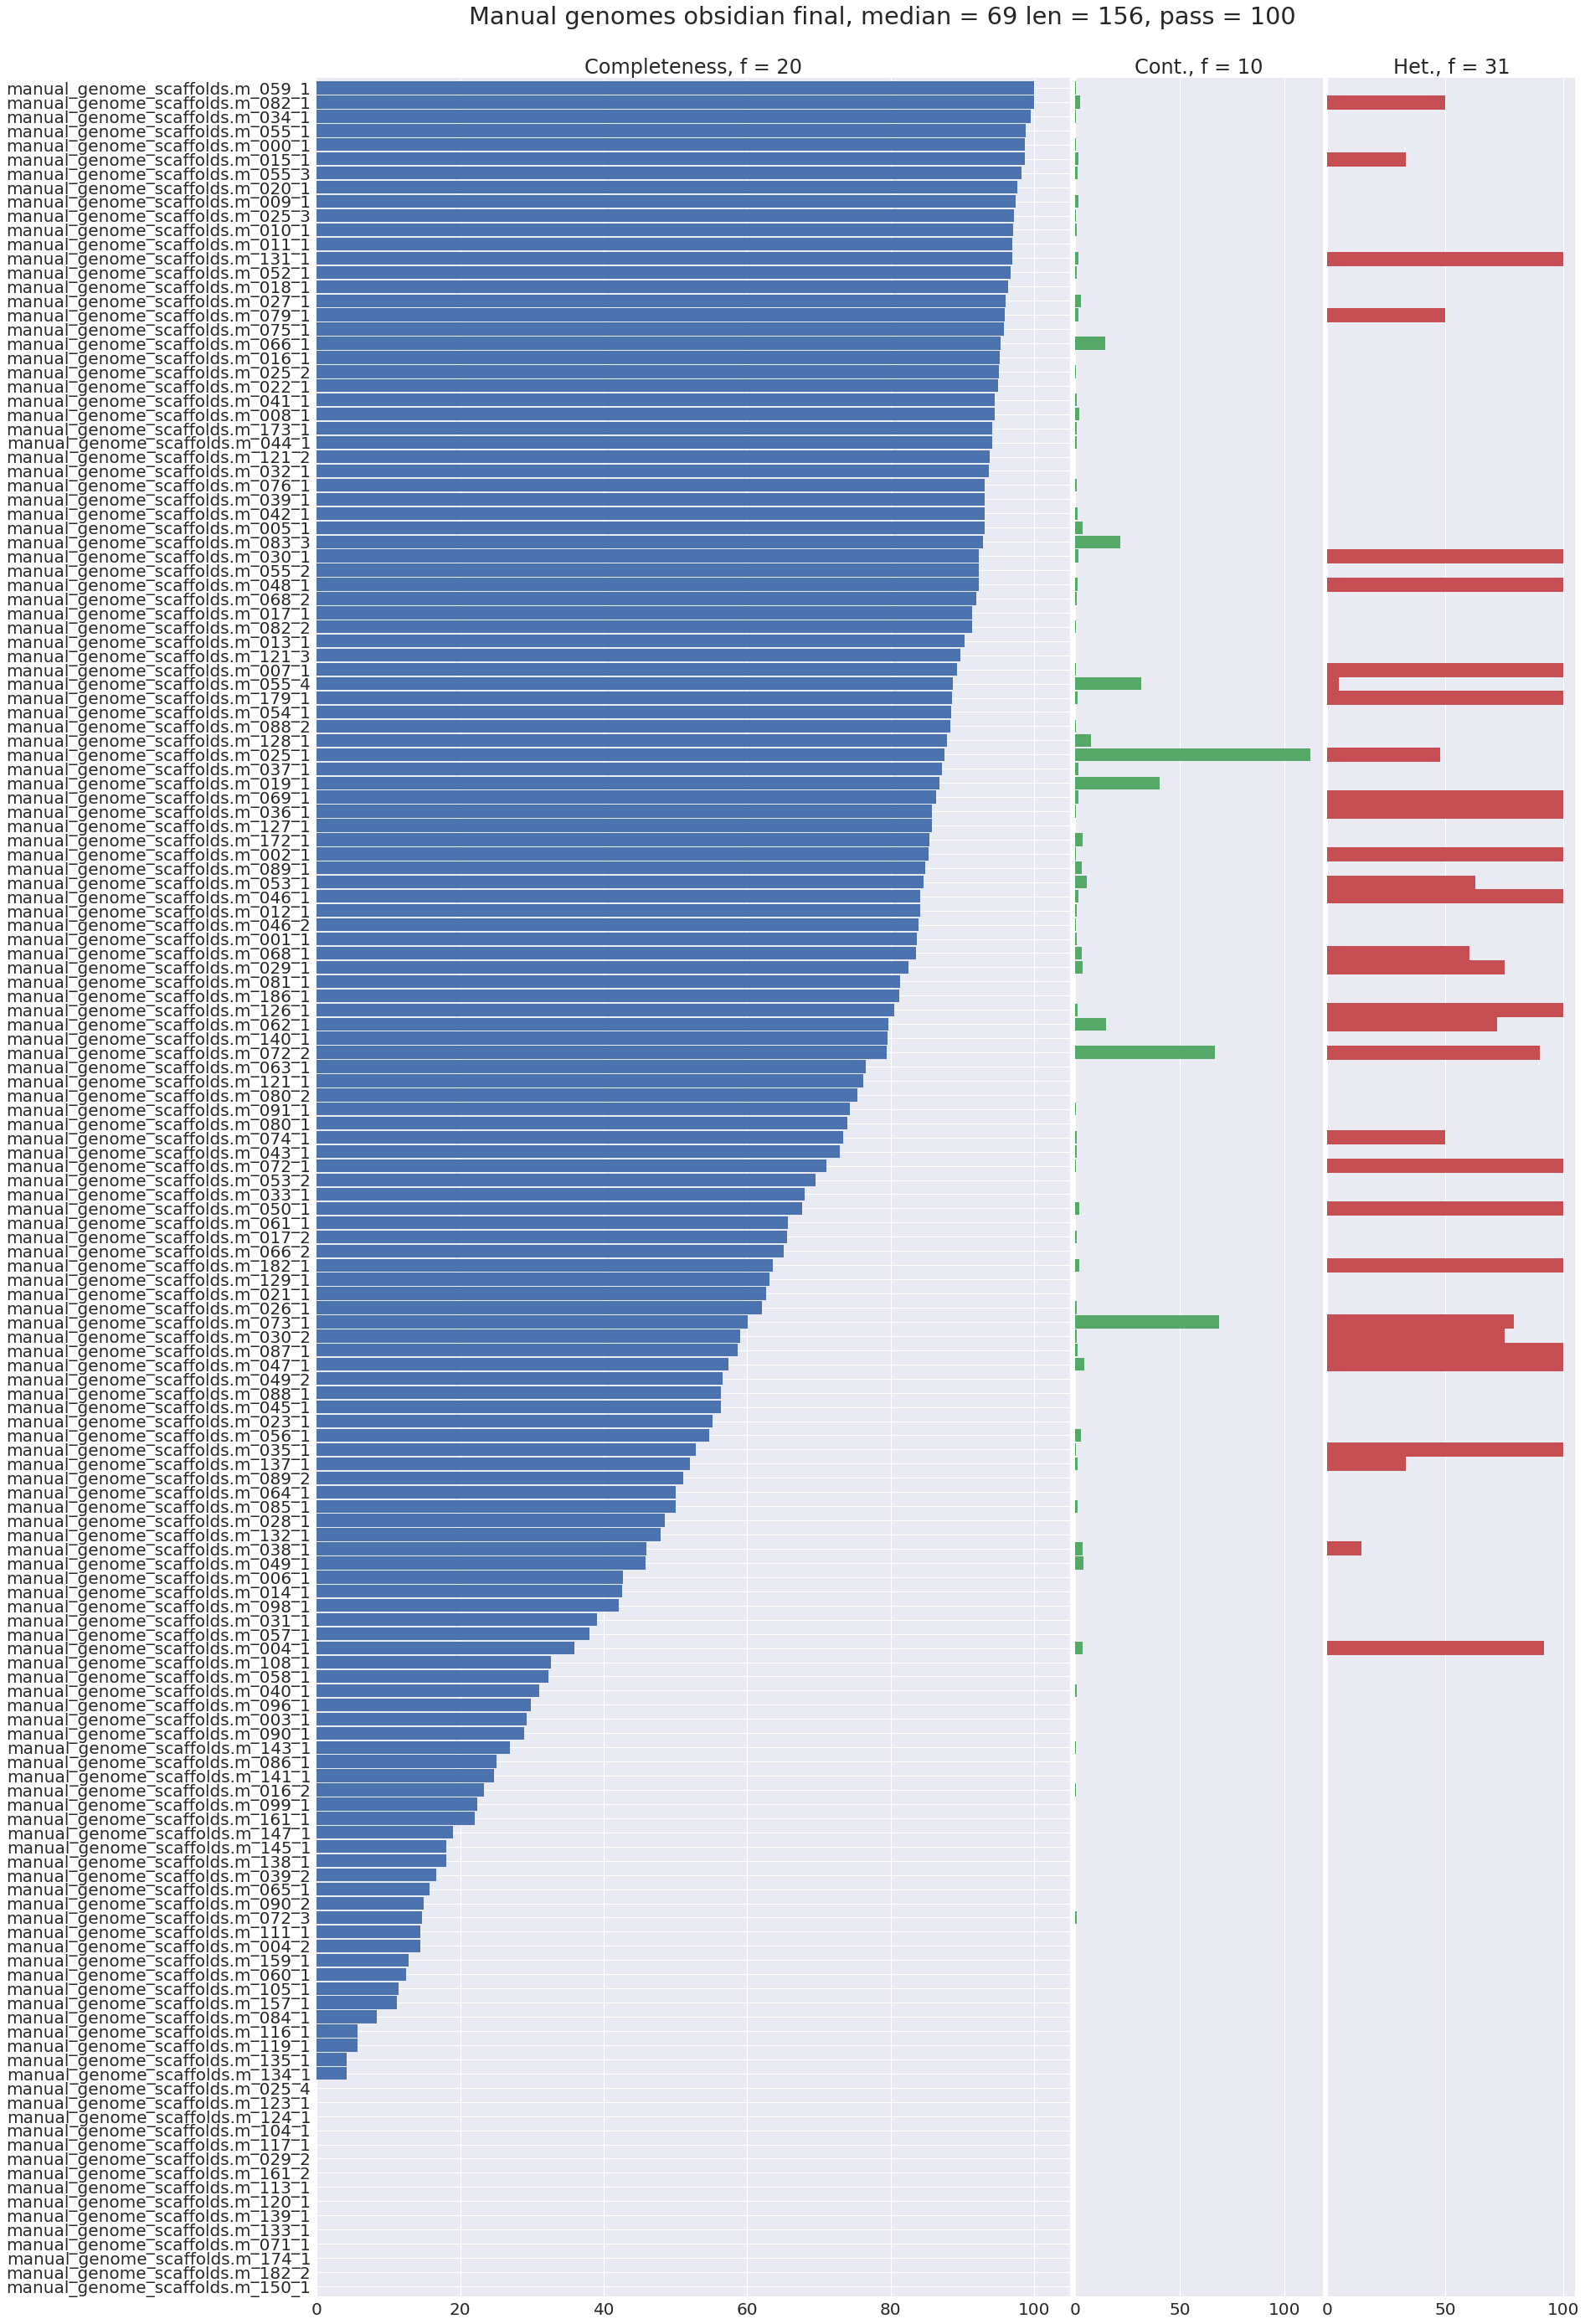

0


In [758]:
metaTake2_oi['Completeness'].median()
filedir = 'Checkm/Manual_genomes_obs/round2_results/'
#metafile_take1_r2 = make_checkm_output_df(filedir)

filedir = 'Checkm/Manual_genomes_obs_take2/'
tit = 'Manual genomes obsidian final'
metaTake2_fail= plot_overview(filedir,metaTake2,tit)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


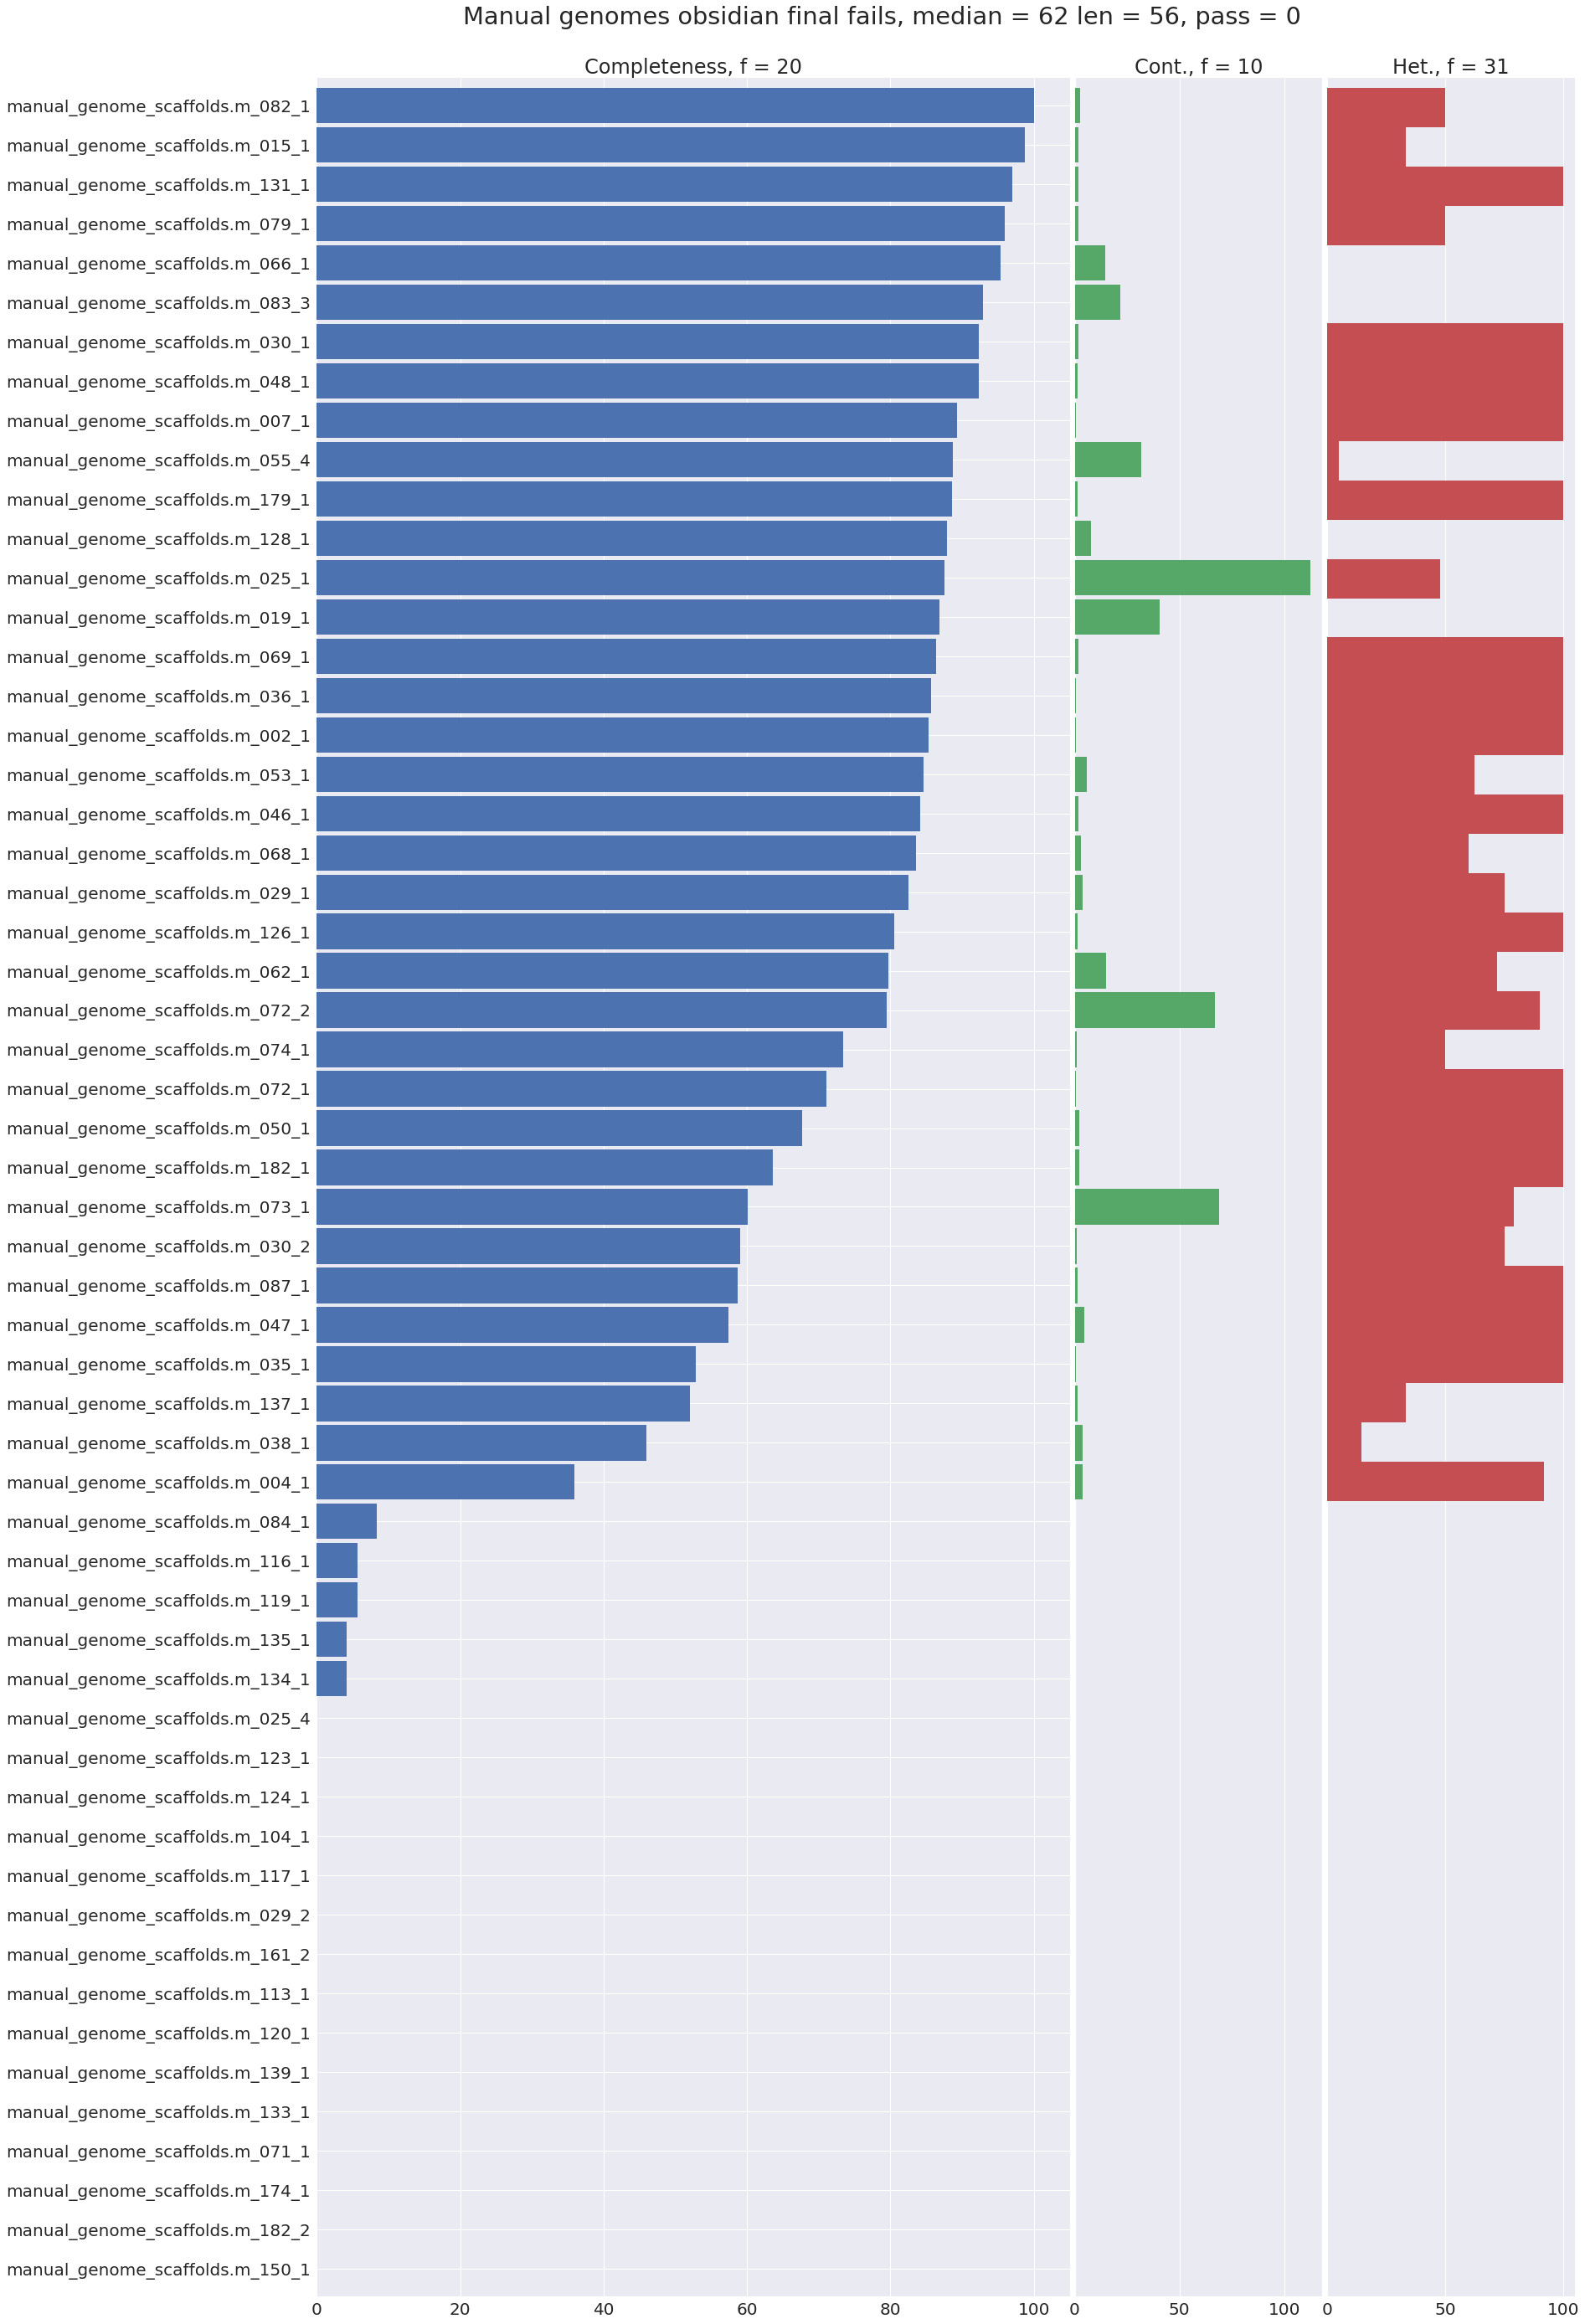

0


,marker lineage,Completeness,Contamination,# contigs,Genome size,# genomes,# marker sets,# markers,# predicted genes,Coding density,GC,GC std,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,old_idx,sample
0,,,,,,,,,,,,,,,,,,
manual_genome_scaffolds.m_082_1,c__Thermoprotei,100,2.38095,101,1977891,54,168,217,2251,0.887667,0.381021,0.0210287,143751,19583.1,32805,50.00,M82_1,Obs6
manual_genome_scaffolds.m_015_1,c__Thermoprotei,98.7342,1.58228,45,1571594,41,158,245,1644,0.894352,0.478019,0.016971,132064,34921.9,59167,33.33,M15_1,Obs2
manual_genome_scaffolds.m_131_1,c__Thermoprotei,97.0238,1.78571,65,1443243,54,168,217,1651,0.911959,0.3811,0.0113749,123904,22203.7,31489,100.00,Obs4_meta_20_1,Obs4
manual_genome_scaffolds.m_079_1,p__Euryarchaeota,95.9677,1.6129,38,1304214,148,124,187,1333,0.900889,0.359487,0.0122722,135724,34321.2,55835,50.00,M79_1,Obs6
manual_genome_scaffolds.m_066_1,k__Archaea,95.3074,14.5631,79,1461920,207,103,145,1498,0.871216,0.635742,0.025008,101990,18503.7,25543,0.00,M66_1,Obs6
manual_genome_scaffolds.m_083_3,c__Thermoprotei,92.8571,21.7262,196,2185184,54,168,217,2517,0.902328,0.316984,0.0213236,57342,11148.9,14137,0.00,M83_3,Obs6
manual_genome_scaffolds.m_030_1,c__Betaproteobacteria,92.2747,1.76723,84,2748151,323,233,386,2594,0.907245,0.654974,0.0147996,122554,32716.1,47996,100.00,M30_1,Obs3
manual_genome_scaffolds.m_048_1,c__Thermoprotei,92.2619,1.19048,49,1043051,54,168,217,1197,0.919083,0.524053,0.0279014,96887,21286.7,31440,100.00,M48_1,Obs4
manual_genome_scaffolds.m_007_1,c__Thermoprotei,89.2405,0.632911,65,1293076,41,158,245,1412,0.878912,0.425219,0.0113799,90291,19893.5,27292,100.00,M07_1,Obs2


In [761]:
len(metaTake2_fail)
#metaTake2_fail_oi = get_old_bin_names(metaTake2_fail,26,29)
metaTake2_fail_oi
filedir = 'Checkm/Manual_genomes_obs_take2/'
tit = 'Manual genomes obsidian final fails'
plot_overview(filedir,metaTake2_fail,tit)

In [664]:
type(labels[0])

matplotlib.text.Text

In [743]:
metaTake2_l = metaTake2[metaTake2['Completeness']>10]
metaTake2[metaTake2.index.isin(metaTake2_l.index)]

,marker lineage,Completeness,Contamination,# contigs,Genome size,# genomes,# marker sets,# markers,# predicted genes,Coding density,GC,GC std,Longest contig,Mean contig length,N50 (contigs),Strain heterogeneity,old_idx,sample
0,,,,,,,,,,,,,,,,,,
manual_genome_scaffolds.m_059_1,k__Bacteria,100,0.50813,29,1668857,138,246,336,1758,0.938312,0.414564,0.0113255,277241,57540.1,151053,0.00,M59_1,Obs5
manual_genome_scaffolds.m_082_1,c__Thermoprotei,100,2.38095,101,1977891,54,168,217,2251,0.887667,0.381021,0.0210287,143751,19583.1,32805,50.00,M82_1,Obs6
manual_genome_scaffolds.m_034_1,k__Bacteria,99.5935,0.50813,27,1694161,138,246,336,1783,0.937724,0.414799,0.00975437,239848,62739.5,121038,0.00,M34_1,Obs3
manual_genome_scaffolds.m_055_1,c__Thermoprotei,98.8095,0,67,2170883,54,168,217,2405,0.889727,0.350806,0.0112312,156854,32401.2,62773,0.00,M55_1,Obs4
manual_genome_scaffolds.m_000_1,k__Bacteria,98.7805,0.50813,37,1595505,138,246,336,1696,0.939034,0.412494,0.00935737,170142,43116.4,121218,0.00,M00_1,Obs2
manual_genome_scaffolds.m_015_1,c__Thermoprotei,98.7342,1.58228,45,1571594,41,158,245,1644,0.894352,0.478019,0.016971,132064,34921.9,59167,33.33,M15_1,Obs2
manual_genome_scaffolds.m_055_3,c__Thermoprotei,98.2143,1.19048,59,1930740,54,168,217,2105,0.886622,0.324153,0.0090331,155407,32724.2,55882,0.00,M55_3,Obs4
manual_genome_scaffolds.m_020_1,c__Thermoprotei,97.619,0,83,2048714,54,168,217,2329,0.879234,0.381391,0.0214124,153635,24683.3,61410,0.00,M20_1,Obs2
manual_genome_scaffolds.m_009_1,c__Thermoprotei,97.4684,1.58228,38,1607278,41,158,245,1833,0.885283,0.386515,0.0129259,383878,42294.2,102680,0.00,M09_1,Obs2
